# PD Model Development

#### Table of Contents

- [Import e Setup](#Import_e_Setup)
- [STEP 0: Reading and pre-configuration of the inputs](#Inputs_Initialization)
    1. [Reading the initial input data](#read_file)
    2. [Reading the configs](#configs)
    3. [Parameters Adjustment](#params_adj)
- [STEP 1: Feature engineering](#feat_eng) 
- [STEP 2: Join Information](#join_tabs) 
- [STEP 3: Manage Outliers](#outliers) 
    1. [Outliers Fitting Parameters](#outliers_fit)
    2. [Outliers replacement](#outliers_replace)  
- [STEP 4: Binning](#binning_fit) 
- [STEP 5: Calculate Default Curve](#def_curve)
- [STEP 6: Calculate Percentage Missing](#perc_missing) 
- [STEP 7: Calculate Accuracy Ratio FIT](#s7_ar_calc) 
- [STEP 8: Calculate Accuracy Ratio Replace](#s7_ar_repl) 
- [STEP 8B: Calculate Correct Classification Rate](#calc_tcorr)
- [STEP 9: Missing Values Management Fit](#missing_fit) 
- [STEP 10: Missing Values Management Replace](#missing_replace) 
- [STEP 11: Calculate Correlation Fit](#biv_corr_fit) 
- [STEP 11B: Calculate Correlation Replace](#biv_corr_replace) 
- [STEP 12: StepWise 5Percent](#stepwise_5perc) 
- [STEP 13: StepWise 1 Percent](#stepwise_1perc) 
- [STEP 14MOD: Expert Final Model](#final_model) 
- [STEP 14: Compute Score And Probabilities](#score_prob) 
- [STEP 15A: Calculate Performance_ar](#report_AR) 
- [STEP 15B: Calculate Performance_tcorr](#report_TCORR) 
- [STEP 15C: Calculate Performance_tdef](#report_TDEF) 

### Summary Inputs / Outputs

- **Initial Inputs**<br>
DS_BALANCE_SHEET >> ds_bs<br>
DS_CUSTOMER_SAMPLE >> ds_cs<br>
DS_GROUP_INFORMATION >> ds_gi<br>
- **Config Files**<br>
params_outlier_perc_tab<br>
LongList_Variables_tab<br>
LongList_Variables_tab_full<br>
params_binning_raw<br>
- **Outputs of steps**<br>
DEV_01_00_BALANCE_SHEET_FEATURES<br>
DEV_02_00_BASE_TABLE<br>
DEV_04_00_BASE_TABLE_OUTLIERS<br>
DEV_05_00_DEFAULT_CURVE<br>
DEV_06_00_PERCENTAGE_MISSING<br>
DEV_08_00_ACCURACY_RATIO_STEP2<br>
DEV_10_00_MISSING_VALUE_MANAGEMENT_STEP2<br>
DEV_11_00_CORRELATION<br>
DEV_14_00_SCORES_AND_PROBABILITIES<br>
- **Parameters**<br>
(P) will be saved for Application part<br>
  1. outlier management params<br>
    DEV_03_00_PERCENTILE_PARAMS >> params_outlier_perc_tab<br>
  2. univariate analysis params<br>
    DEV_07_00_ACCURACY_RATIO_STEP1 >> params_AR_tab <br>
  3. missing values management<br>
    DEV_09_00_NEUTRAL_NUMBERS >> params_missing_fit_tab<br>
  4. bivariate analysis params<br>
    DEV_11_01_CORRELATION_Report >> report_bivariate_corr_tab<br>
- **Models**
    1. model_stepwise_5perc_raw.pkl (Detailed)
    2. model_stepwise_1perc_raw.pkl (Detailed)
    3. model_final_tab.pkl (Detailed)
- **Performance Reports**
    1. report_final_model_AR_tab.pkl (Tabular)
    2. report_final_model_TCORR_tab.pkl (Tabular)
    3. report_final_model_TDEF_tab.pkl (Tabular)

### - Import e Setup Session <a name="Import_e_Setup"></a>

### utils

In [1]:
### if needed [%run utils_functions.ipynb]

In [2]:
##PATHS
project_path = 'WestPac/Development/'
in_path = project_path + 'Data/' #jupyter_path + project_path + '/data/' ##if not using workdir
out_path = project_path + 'Data/' #jupyter_path + project_path + '/out/' ##if not using workdir

path_configs =  project_path + 'Data/' #out_path + 'Configs_Params/'

In [3]:
##Work directory
import os
os.chdir('/home/jovyan')
os.getcwd()

'/home/jovyan'

### imports

In [4]:
#system
import os

#base
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import string

# print config dicts
from pprint import pprint as dict_print

#visual functions
from IPython.display import Image
from IPython.display import display

from datetime import datetime
today = datetime.today().strftime('%Y%m%d')

In [5]:
#promlib_stats

## data analysis
from promlib_stats.data_analysis.binning import binning
from promlib_stats.data_analysis.matrix_corr import matrix_corr
 
## estimation
from promlib_stats.estimation.stepwise_binomial import stepwise_binomial

## performance
from promlib_stats.performance.tdef import tdef
from promlib_stats.performance.lorenz import lorenz
from promlib_stats.performance.tcorr import tcorr

## Step 0: Reading and pre-configuration of the clean Data <a name="Inputs_Initialization"></a>

### S0_1: Reading the initial input data <a name="read_file"></a>

In [6]:
# balance sheet
file_bs = in_path + 'DS_BALANCE_SHEET.csv'
ds_bs = pd.read_csv(file_bs)

# customer sample
file_cs = in_path + 'DS_CUSTOMER_SAMPLE.csv'
ds_cs = pd.read_csv(file_cs)

#group information
file_gi = in_path + 'DS_GROUP_INFORMATION.csv'
ds_gi = pd.read_csv(file_gi)

- Summary info > (unhide if needed)

### S0_2: Reading the Config Files <a name="configs"></a>

In [7]:
# outlier perc
params_path = path_configs + '/params_outlier_perc_tab.pkl'
perc = pd.read_pickle(params_path)

# long list variable
vars_path_pkl = path_configs + '/LongList_Variables_tab.pkl'
longlist_vars = pd.read_pickle(vars_path_pkl)

# long list variable
vars_path_pkl = path_configs + '/LongList_Variables_tab_full.pkl'
longlist_vars_full = pd.read_pickle(vars_path_pkl)

# params binning
file_path = path_configs + '/params_binning_raw.pkl'
with open(file_path, 'rb') as file:
    params_binning = pickle.load(file)

### S0_3: Parameters Adjustment <a name="params_adj"></a>

- parameter values files

In [8]:
# Generic
Application = False
feat_list = longlist_vars.IND_LABEL.to_list()

#Step 4
binning_subset_list = ['IC_183', 'ROE']

#Step 5
def_curve_feat_list = ['C_LIAB_REV', 'I_11bis', 'I_100']

## Step 1: Feature engineering <a name="feat_eng"></a>

In [9]:
db = ds_bs.copy()

- all steps below can be constructed using earlywarning kernel libs

In [10]:
# VARIABLES NECESSARY TO BUILD INDICATORS

In [11]:
bs_2 = db.replace(r'^\s*$', np.nan, regex=True)

# VARIABLES NECESSARY TO BUILD INDICATORS

bs_2['CASHFLOW'] = np.round(np.nansum(
    [bs_2['RISNERET'], bs_2['AMMIMMAT'], bs_2['SVALCRED'], bs_2['ACCRISON'], bs_2['AMMIMIMM']], axis=0), 3)

bs_2['CASHFLOW2'] = np.round(np.nansum([bs_2['RISNERET'], bs_2['AMMIMMAT'],
                                bs_2['SVALCRED'], bs_2['ACCRISON'], bs_2['AMMIMIMM'], -bs_2['ALSVALIM']], axis=0), 3)

bs_2['RISEXESE'] = np.round(np.nansum(
    [bs_2['RIPVASVA'], bs_2['ONPROSTR']], axis=0), 3)

bs_2['RISEXESE2'] = np.round(np.nansum(
    [bs_2['RIPVASVA'], bs_2['ONPROSTR'], bs_2['PLMINRE']], axis=0), 3)

bs_2['CREDBR'] = np.round(np.nansum(
    [bs_2['CRCOMBR'], bs_2['CRFINBR'], bs_2['CRALBR']], axis=0), 3)

bs_2['RISERVE'] = np.round(np.nansum(
    [bs_2['RISSOVRP'], bs_2['ALRIS']], axis=0), 3)

bs_2['DEBFORN'] = np.round(np.nansum(
    [bs_2['DECOALML'], bs_2['DEFORNBR']], axis=0), 3)

bs_2['CAPCIRC'] = np.round(np.nansum([bs_2['CAPNP'], -bs_2['IMIMMAT'], -bs_2['IMMATBR'], -
                              bs_2['IMMATCOR'], -bs_2['ATFINIMM'], bs_2['FONDIACC'], bs_2['DEBF']], axis=0), 3)

bs_2['ATREAL'] = np.round(np.nansum(
    [bs_2['TOTATCOR'], -bs_2['MAGA'], -bs_2['LIQUIDIT']], axis=0), 3)

bs_2['SOPF'] = np.round(np.nansum([bs_2['OF'], -bs_2['PFN']], axis=0), 3)

bs_2['DEBTMDL'] = np.round(np.nansum(
    [bs_2['TOTCAPPE'], -bs_2['CAPNP']], axis=0), 3)

bs_2['CAPTERZ'] = np.round(np.nansum(
    [bs_2['TOTCAPPE'], -bs_2['CAPNP'], bs_2['TOPASCOR']], axis=0), 3)

bs_2['IMMNE'] = np.round(np.nansum(
    [bs_2['IMIMMAT'], bs_2['IMMATBR'], bs_2['IMMATCOR']], axis=0), 3)

bs_2['CAPINVTAN'] = np.round(np.nansum(
    [bs_2['IMMNE'], bs_2['MAGA'], bs_2['CRCOMBR'], bs_2['CRCODIML'], -bs_2['DECOALML'], -bs_2['DECOBR']], axis=0), 3)

bs_2['DBTOT'] = np.round(np.nansum(
    [bs_2['DEBF'], bs_2['TOPASCOR']], axis=0), 3)

bs_2['AMMTOT'] = np.round(np.nansum(
    [bs_2['AMMIMMAT'], bs_2['AMMIMIMM']], axis=0), 3)

bs_2['COSTPROD'] = np.round(np.nansum(
    [bs_2['MATPRICO'], -bs_2['ACQCONS'], bs_2['SER'], bs_2['CL1']], axis=0), 3)

bs_2['CAPCIRCOP'] = np.round(np.nansum(
    [bs_2['MAGA'], bs_2['CRCOMBR'], bs_2['CRALBR'], -bs_2['DECOBR'], -bs_2['DEDIVBR']], axis=0), 3)

bs_2['SGF'] = np.round(np.nansum([bs_2['PFN'], -bs_2['OF']], axis=0), 3)

bs_2['TOT_COST_OP'] = np.round(np.nansum([bs_2['MATPRICO'], -bs_2['ACQCONS'], bs_2['SER'],
                                  bs_2['CL1'], bs_2['AMMIMMAT'], bs_2['SVALCRED'], bs_2['ACCRISON']], axis=0), 3)

bs_2['VALAGGCOM'] = np.round(np.nansum([bs_2['VALAGGOP'], bs_2['SALRIOND'], bs_2['ALSVALIM'],
                                bs_2['PFN'], bs_2['PLMINRE'], bs_2['ONPROSTR'], bs_2['RIPVASVA']], axis=0), 3)

bs_2['VL1'] = np.round(np.nansum([bs_2['IMIMMAT'], bs_2['IMMATBR'],
                          bs_2['CREFI'], bs_2['MAGA'], bs_2['CRCOMBR'], bs_2['CRALBR']], axis=0), 3)

bs_2['CAPCIRCOP_FUN'] = np.round(np.nansum(
    [bs_2['CAPCIRCOP'], -bs_2['DECOALML'], bs_2['DISTDELI']], axis=0), 3)

bs_2['CAP_INV_OPE_NET'] = np.round(np.nansum(
    [bs_2['IMMNE'], bs_2['CRCODIML'], bs_2['CAPCIRCOP_FUN'], -bs_2['ALFO'], -bs_2['TFPR']], axis=0), 3)

bs_2['POS_FIN_NETTA'] = np.round(np.nansum(
    [bs_2['ATTLIQ'], bs_2['CRFINBR'], -bs_2['DEFIBR'], bs_2['DEBF'], -bs_2['DECOALML'], bs_2['TFPR']], axis=0), 3)

bs_2['INDEB_FIN_NETTO'] = np.round(np.nansum(
    [bs_2['DEFIBAML'], bs_2['DEFIALML'], bs_2['DEFIBR'], -bs_2['ATTLIQ']], axis=0), 3)

# CORRECTION OF VARIABLES WITH NEGATIVE ENTRIES

list_clip = ['IMIMMAT', 'IMMATLO', 'FONAMMSV', 'IMMATBR', 'IMMATCOR', 'IMFIP', 'CREFI', 'CRCODIML', 'ATFINIMM', 'TOTATIMM', 'ACCAFORN',
             'MATPRIM', 'MAGA', 'CRCOMBR', 'CRFINBR', 'CRALBR', 'CREDI', 'ATTLIQ', 'LIQUIDIT', 'TOTATCOR', 'TOTATT', 'ALFO',
             'TFPR', 'FONDIACC', 'OBBLIML', 'DEFISOML', 'DEFIBAML', 'DEFIALML', 'DECOALML', 'DEBF', 'TOTCAPPE', 'DEBABR', 'DEFIALBR',
             'DEFIBR', 'DEFORNBR', 'ACCOBR', 'DECOBR', 'DEDIVBR', 'TOPASCOR', 'TOPASPNE', 'RICNET', 'AMMIMMAT',
             'AMMIMIMM', 'ATREAL', 'DEBTMDL', 'CAPTERZ', 'DBTOT', 'AMMTOT']

bs_2[list_clip] = bs_2[list_clip].clip(lower=0)

db_new = bs_2
db_new['I_1'] = db_new['RISNERET']/db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_2'] = (db_new['MON']+db_new['RISEXESE']+db_new['SALRIOND'] -
                 db_new['AMMIMIMM'])/db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_2bis'] = (db_new['MON']+db_new['RISEXESE2']+db_new['SALRIOND'] -
                    db_new['AMMIMIMM'])/db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_3'] = db_new['RISNERET']/db_new['CAPNP'].where(db_new['CAPNP'] > 0)
db_new['ROE'] = db_new['RISNERET'] / \
    (db_new['CAPNP']+db_new['DISTDELI']
     ).where((db_new['CAPNP']+db_new['DISTDELI']) > 0)
db_new['I_4'] = db_new['RISNERET']/db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_5'] = db_new['MON']/db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_6'] = db_new['MON']/(db_new['TOTATT']+db_new['FONAMMSV']
                               ).where((db_new['TOTATT']+db_new['FONAMMSV']) > 0)
db_new['I_7'] = db_new['MON']/db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_8'] = db_new['RISRETAI']/db_new['MON'].where(db_new['MON'] > 0)
db_new['I_9'] = db_new['RISRETAI'] / \
    (db_new['OF']+db_new['RISRETAI']
     ).where((db_new['OF']+db_new['RISRETAI']) > 0)
db_new['I_10'] = db_new['MON']/db_new['OF'].where(db_new['OF'] > 0)
db_new['I_11'] = db_new['CASHFLOW']/db_new['OF'].where(db_new['OF'] > 0)
db_new['I_11bis'] = db_new['CASHFLOW2']/db_new['OF'].where(db_new['OF'] > 0)
db_new['I_12'] = db_new['CASHFLOW'] / \
    db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_12bis'] = db_new['CASHFLOW2'] / \
    db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_13'] = db_new['CASHFLOW'] / \
    db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_13bis'] = db_new['CASHFLOW2'] / \
    db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_14'] = db_new['CASHFLOW'] / \
    (db_new['TOTATT']+db_new['FONAMMSV']
     ).where((db_new['TOTATT']+db_new['FONAMMSV']) > 0)
db_new['I_15'] = db_new['CASHFLOW'] / \
    (db_new['DEBF']+db_new['TOPASCOR']
     ).where((db_new['DEBF']+db_new['TOPASCOR']) > 0)
db_new['I_15bis'] = db_new['CASHFLOW2'] / \
    (db_new['DEBF']+db_new['TOPASCOR']
     ).where((db_new['DEBF']+db_new['TOPASCOR']) > 0)
db_new['I_16'] = db_new['CASHFLOW'] / \
    db_new['TOPASCOR'].where(db_new['TOPASCOR'] > 0)
db_new['I_16bis'] = db_new['CASHFLOW2'] / \
    db_new['TOPASCOR'].where(db_new['TOPASCOR'] > 0)
db_new['I_17'] = db_new['VALPROD']/db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_18'] = db_new['VALAGGOP'] / \
    db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_19'] = db_new['MOL']/db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_20'] = db_new['MOL']/db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_21'] = db_new['MOL'] / \
    (db_new['TOTATT']+db_new['FONAMMSV']
     ).where((db_new['TOTATT']+db_new['FONAMMSV']) > 0)
db_new['I_22'] = db_new['MOL']/db_new['OF'].where(db_new['OF'] > 0)
db_new['I_23'] = db_new['VALPROD'] / \
    db_new['IMMATLO'].where(db_new['IMMATLO'] > 0)
db_new['I_24'] = (db_new['RISNERET']+db_new['AMMIMMAT']) / \
    db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_25'] = db_new['MON']/db_new['MOL'].where(db_new['MOL'] > 0)
db_new['I_26'] = db_new['RICNET']/db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_28'] = db_new['CAPNP']/db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_29'] = db_new['IMMATBR']/db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_30'] = db_new['IMMATLO']/db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_31'] = db_new['RICNET'] / \
    db_new['TOTATCOR'].where(db_new['TOTATCOR'] > 0)
db_new['I_33'] = db_new['LIQUIDIT'] / \
    db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_36'] = (db_new['LIQUIDIT']+db_new['CREDBR']) / \
    db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_38'] = (db_new['TOTATCOR']-db_new['TOPASCOR']) / \
    db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_39'] = (db_new['TOTATCOR']-db_new['DECOBR']) / \
    db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_40'] = (db_new['TOTATCOR']-db_new['TOPASCOR'])/(db_new['TOTATT'] -
                                                          db_new['CAPNP']).where((db_new['TOTATT']-db_new['CAPNP']) > 0)
db_new['I_41'] = (db_new['TOTATCOR']-db_new['TOPASCOR']) / \
    db_new['TOTCAPPE'].where(db_new['TOTCAPPE'] > 0)
db_new['I_42'] = (db_new['TOTATCOR']-db_new['TOPASCOR'])/(db_new['RICNET'] +
                                                          db_new['SCFIN']).where((db_new['RICNET']+db_new['SCFIN']) > 0)
db_new['I_43'] = db_new['RICNET']/db_new['MAGA'].where(db_new['MAGA'] > 0)
db_new['I_44'] = (db_new['RICNET']+db_new['SCFIN']) / \
    db_new['MAGA'].where(db_new['MAGA'] > 0)
db_new['I_46'] = db_new['DEBFORN'] / \
    db_new['MATPRICO'].where(db_new['MATPRICO'] > 0)
db_new['I_47'] = (db_new['TOPASCOR']+db_new['DEBF']+db_new['FONDIACC']
                  )/db_new['MATPRICO'].where(db_new['MATPRICO'] > 0)
db_new['I_48'] = db_new['TOPASCOR'] / \
    db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_49'] = db_new['DEBABR']/db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_50'] = db_new['CL1']/db_new['VALPROD'].where(db_new['VALPROD'] > 0)
db_new['I_51'] = db_new['FONAMMSV'] / \
    db_new['IMMATLO'].where(db_new['IMMATLO'] > 0)
db_new['I_52'] = db_new['AMMIMMAT'] / \
    db_new['IMMATLO'].where(db_new['IMMATLO'] > 0)
db_new['I_53'] = db_new['CAPNP']/(db_new['TOPASCOR']+db_new['DEBF']+db_new['FONDIACC']).where(
    (db_new['TOPASCOR']+db_new['DEBF']+db_new['FONDIACC']) > 0)
db_new['I_55'] = db_new['CAPNP'] / \
    db_new['TOPASCOR'].where(db_new['TOPASCOR'] > 0)
db_new['I_56'] = db_new['CAPNP'] / \
    (db_new['DEBF']+db_new['DEBABR']
     ).where((db_new['DEBF']+db_new['DEBABR']) > 0)
db_new['I_57'] = db_new['CAPNP']/db_new['DEBF'].where(db_new['DEBF'] > 0)
db_new['I_58'] = db_new['CRCOMBR']/db_new['MAGA'].where(db_new['MAGA'] > 0)
db_new['I_59'] = (db_new['LIQUIDIT']-db_new['DEBABR'] -
                  db_new['DEFIALBR'])/db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_60'] = (db_new['TOPASCOR']+db_new['DEBF'] +
                  db_new['FONDIACC'])/db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_61'] = db_new['TOTATCOR'] / \
    db_new['TOPASCOR'].where(db_new['TOPASCOR'] > 0)
db_new['I_62'] = (db_new['CREDBR']+db_new['LIQUIDIT']) / \
    db_new['TOPASCOR'].where(db_new['TOPASCOR'] > 0)
db_new['I_63'] = db_new['LIQUIDIT'] / \
    db_new['TOPASCOR'].where(db_new['TOPASCOR'] > 0)
db_new['I_64'] = db_new['LIQUIDIT'] / \
    db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_65'] = db_new['TOPASCOR'] / \
    db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_66'] = (db_new['DEFIBAML']+db_new['DEBABR']) / \
    db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_67'] = db_new['TOTATCOR'] / \
    db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_68'] = (db_new['LIQUIDIT']+db_new['CREDBR']) / \
    db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_69'] = (db_new['TOTATCOR']-db_new['TOPASCOR']) / \
    db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_70'] = db_new['TOTCAPPE'] / \
    db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_71'] = db_new['TOTCAPPE'] / \
    db_new['TOTATIMM'].where(db_new['TOTATIMM'] > 0)
db_new['I_72'] = db_new['IMMATBR']/db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_73'] = db_new['IMMATLO']/db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_75'] = (db_new['TOTATT']-db_new['CAPNP']) / \
    db_new['TOTATCOR'].where(db_new['TOPASCOR'] > 0)
db_new['I_76'] = db_new['DEBF'] / \
    db_new['TOPASCOR'].where(db_new['TOPASCOR'] > 0)
db_new['I_77'] = (db_new['CAPNP']+db_new['FONAMMSV']) / \
    db_new['IMMATLO'].where(db_new['IMMATLO'] > 0)
db_new['I_78'] = db_new['CAPNP']/db_new['IMMATBR'].where(db_new['IMMATBR'] > 0)
db_new['I_79'] = db_new['TOTCAPPE'] / \
    db_new['IMMATBR'].where(db_new['IMMATBR'] > 0)
db_new['I_80'] = db_new['OF']/db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_81'] = db_new['RISERVE']/db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_82'] = (db_new['TOTATCOR']-db_new['DECOBR']) / \
    db_new['DEBABR'].where(db_new['DEBABR'] > 0)
db_new['I_83'] = db_new['RISRETAI'] / \
    db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_84'] = db_new['MON']/(db_new['DEBF']+db_new['DEBABR']+db_new['DEFIALBR']).where(
    (db_new['DEBF']+db_new['DEBABR']+db_new['DEFIALBR']) > 0)
db_new['I_85'] = db_new['RISRETAI']/db_new['CAPNP'].where(db_new['CAPNP'] > 0)
db_new['I_86'] = db_new['VALAGGOP'] / \
    db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_87'] = db_new['AMMIMMAT'] / \
    db_new['IMMATBR'].where(db_new['IMMATBR'] > 0)
db_new['I_88'] = db_new['MAGA'] / \
    (db_new['MATPRICO']+db_new['ACQCONS']
     ).where((db_new['MATPRICO']+db_new['ACQCONS']) > 0)
db_new['I_89'] = db_new['DEBF']/db_new['TOTATT'].where(db_new['TOTATT'] > 0)
db_new['I_90'] = db_new['OF'] / \
    (db_new['DEBF']+db_new['TOPASCOR']
     ).where((db_new['DEBF']+db_new['TOPASCOR']) > 0)
db_new['I_91'] = db_new['OF'] / \
    (db_new['DEBF']+db_new['DEFIBR']
     ).where((db_new['DEBF']+db_new['DEFIBR']) > 0)
db_new['I_92'] = (db_new['MON']/db_new['TOTATT'].where(db_new['TOTATT'] > 0))-(db_new['OF']/(db_new['DEBF']+db_new['DEBABR']+db_new['DEFIALBR']).where(
    (db_new['DEBF']+db_new['DEBABR']+db_new['DEFIALBR']) > 0))*((db_new['DEBF']+db_new['DEBABR']+db_new['DEFIALBR'])/db_new['CAPNP'].where(db_new['CAPNP'] > 0))
db_new['I_93'] = db_new['MOL']/(db_new['OF']*0.25*(db_new['DEBF']+db_new['DEFIBR'])).where(
    (db_new['OF']*0.25*(db_new['DEBF']+db_new['DEFIBR'])) > 0)
db_new['I_94'] = (db_new['LIQUIDIT']+db_new['CAPNP']-db_new['TOTATIMM'] -
                  db_new['TOPASCOR'])/(2*db_new['TOTATT']).where((2*db_new['TOTATT']) > 0)
db_new['I_95'] = db_new['AMMIMMAT'] / \
    db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['I_96'] = pd.Series(
    np.log(db_new['TOTATT'].where(db_new['TOTATT'] > 0)))
db_new['I_99'] = db_new['CASHFLOW'] / \
    db_new['VALAGGOP'].where(db_new['VALAGGOP'] > 0)
db_new['I_99bis'] = db_new['CASHFLOW2'] / \
    db_new['VALAGGOP'].where(db_new['VALAGGOP'] > 0)
db_new['I_101bis'] = db_new['SOPF']/db_new['MOL'].where(db_new['MOL'] > 0)
db_new['SOPF_RIC'] = db_new['SOPF'] / \
    db_new['RICNET'].where(db_new['RICNET'] > 0)
db_new['a'] = db_new['MOL']/db_new['RICNET'].where(db_new['RICNET'] > 0)

db_sorted = db_new.sort_values(by=['GROUP', 'INSTITUTE', 'CIC', 'BS_DATE'])

db_sorted['LRISNERET'] = db_sorted['RISNERET'].shift(1)
db_sorted['LTOPASCOR'] = db_sorted['TOPASCOR'].shift(1)
db_sorted['LMOL'] = db_sorted['MOL'].shift(1)
db_sorted['LCAPNP'] = db_sorted['CAPNP'].shift(1)
db_sorted['LVALAGGOP'] = db_sorted['VALAGGOP'].shift(1)
db_sorted['LRICNET'] = db_sorted['RICNET'].shift(1)
db_sorted['LTOTATT'] = db_sorted['TOTATT'].shift(1)
db_sorted['La'] = db_sorted['a'].shift(1)

db_sorted['YEAR_LAG'] = pd.to_datetime(
    db_sorted['BS_DATE']).dt.year - pd.to_datetime(db_sorted['BS_DATE']).shift(1).dt.year

db_filt = db_sorted.drop(['CAP', 'VERSAZIO', 'RISSOVRP',
                          'AZIOPROP', 'RISNETTE', 'FONAMMSV',
                          'ATFINIMM', 'MATPRIM', 'CREDI', 'CRVSSOC',
                          'CAPVERS', 'RISRIVAL', 'ALRIS', 'UTIESERI',
                          'ALFO', 'TFPR', 'OBBLIML', 'DEFIALBR',
                          'IMPREDD', 'SOPF', 'DEDIVBR', 'SCFIN',
                          'ALSVALIM', 'PFN', 'PLMINRE', 'RIPVASVA',
                          'ONPROSTR', 'RISEXESE', 'RISEXESE2',
                          'CREDBR', 'RISERVE', 'DEBTMDL',
                          'INDEB_FIN_NETTO'], axis=1)

db_filt.loc[(db_filt['YEAR_LAG'] == 1) & (db_filt['LRISNERET'] > 0), 'I_27'] = (
    db_filt['RISNERET']-db_filt['LRISNERET'])/db_filt['LRISNERET']
db_filt.loc[(db_filt['YEAR_LAG'] == 1) & (db_filt['LTOPASCOR'] > 0), 'I_32'] = (
    db_filt['TOPASCOR']-db_filt['LTOPASCOR'])/db_filt['LTOPASCOR']
db_filt.loc[(db_filt['YEAR_LAG'] == 1) & (db_filt['LMOL'] > 0), 'I_34'] = (
    db_filt['MOL']-db_filt['LMOL'])/db_filt['LMOL']
db_filt.loc[(db_filt['YEAR_LAG'] == 1) & (db_filt['LCAPNP'] > 0), 'I_35'] = (
    db_filt['CAPNP']-db_filt['LCAPNP'])/db_filt['LCAPNP']
db_filt.loc[(db_filt['YEAR_LAG'] == 1) & (db_filt['LVALAGGOP'] > 0), 'I_37'] = (
    db_filt['VALAGGOP']-db_filt['LVALAGGOP'])/db_filt['LVALAGGOP']
db_filt.loc[(db_filt['YEAR_LAG'] == 1) & (db_filt['LRICNET'] > 0), 'I_97'] = (
    db_filt['RICNET']-db_filt['LRICNET'])/db_filt['LRICNET']
db_filt.loc[(db_filt['YEAR_LAG'] == 1) & (db_filt['LTOTATT'] > 0), 'I_98'] = (
    db_filt['TOTATT']-db_filt['LTOTATT'])/db_filt['LTOTATT']
db_filt.loc[(db_filt['YEAR_LAG'] == 1) & (db_filt['La'] > 0),
            'mol_fat'] = (db_filt['a']-db_filt['La'])/db_filt['La']

db_filt_sorted = db_filt.sort_values(
    by=['GROUP', 'INSTITUTE', 'CIC', 'BS_DATE'])
first = db_filt_sorted.reset_index().groupby(
    ['GROUP', 'INSTITUTE', 'CIC']).first()
db_filt.loc[first['index'], ['I_27', 'I_32', 'I_34',
                             'I_35', 'I_37', 'I_97', 'I_98', 'mol_fat']] = np.nan

db = db_filt

/tmp/ipykernel_81/1386739242.py:177: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  db_new['I_49'] = db_new['DEBABR']/db_new['RICNET'].where(db_new['RICNET'] > 0)
/tmp/ipykernel_81/1386739242.py:178: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  db_new['I_50'] = db_new['CL1']/db_new['VALPROD'].where(db_new['VALPROD'] > 0)
/tmp/ipykernel_81/1386739242.py:179: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

In [12]:
# Conditional variables for intermediate construction

In [13]:
db.loc[db['TOTATT'] == 0, 'CP_INV'] = 0
db.loc[db['TOTATT'] > 0, 'CP_INV'] = db['CAPNP']/db['TOTATT']

db.loc[(db["TOTATIMM"] == 0) & (db["CAPNP"] > 0), 'CP_IMNET'] = 10
db.loc[(db['TOTATIMM'] == 0) & (db['CAPNP'] <= 0), 'CP_IMNET'] = 0
db.loc[db["TOTATIMM"] > 0, 'CP_IMNET'] = db['CAPNP']/db['TOTATIMM']

db.loc[(db["CAPCIRC"] <= 0) & (db["TOPASCOR"] > 0), 'DBR_CIRC'] = 10
db.loc[(db['CAPCIRC'] <= 0) & (db['TOPASCOR'] == 0), 'DBR_CIRC'] = 0
db.loc[db["CAPCIRC"] > 0, 'DBR_CIRC'] = db['TOPASCOR']/db['CAPCIRC']

db.loc[(db["CAPNP"] <= 0) & (db["CAPTERZ"] > 0), 'CTER_CP'] = 10
db.loc[(db['CAPNP'] <= 0) & (db['CAPTERZ'] == 0), 'CTER_CP'] = 0
db.loc[db["CAPNP"] > 0, 'CTER_CP'] = db['CAPTERZ']/db['CAPNP']

db.loc[(db['RICNET'] == 0) & (db['TOPASCOR'] > 0), 'DBR_FAT'] = 10
db.loc[(db['RICNET'] == 0) & (db['TOPASCOR'] == 0), 'DBR_FAT'] = 0
db.loc[db['RICNET'] > 0, 'DBR_FAT'] = db['TOPASCOR']/db['RICNET']

db.loc[db["SGF"] > 0, 'SGF_FAT'] = 10
db.loc[(db['RICNET'] == 0) & (db['SGF'] == 0), 'SGF_FAT'] = 0
db.loc[(db['RICNET'] == 0) & (db['SGF'] < 0), 'SGF_FAT'] = -10
db.loc[(db['RICNET'] != 0) & (db['SGF'] <= 0),
       'SGF_FAT'] = db['SGF']/db['RICNET']

db.loc[db["SGF"] > 0, 'SGF_ROP'] = 10
db.loc[(db['MON'] <= 0) & (db['SGF'] == 0), 'SGF_ROP'] = 0
db.loc[(db['MON'] <= 0) & (db['SGF'] < 0), 'SGF_ROP'] = -10
db.loc[(db['MON'] > 0) & (db['SGF'] <= 0), 'SGF_ROP'] = db['SGF']/db['MON']

db.loc[(db['RICNET'] == 0) & ((db['TOPASCOR']-db['CAPCIRC']) <= 0), 'DBN_FAT'] = 0
db.loc[(db['RICNET'] == 0) & ((db['TOPASCOR']-db['CAPCIRC']) > 0), 'DBN_FAT'] = 10
db.loc[db['RICNET'] > 0, 'DBN_FAT'] = (
    db['TOPASCOR']-db['CAPCIRC'])/db['RICNET']

db.loc[(db['RICNET'] == 0) & (db['TOTATT'] == 0), 'INV_FAT'] = 0
db.loc[(db['RICNET'] == 0) & (db['TOTATT'] > 0), 'INV_FAT'] = 10
db.loc[db['RICNET'] > 0, 'INV_FAT'] = db['TOTATT']/db['RICNET']

db.loc[(db['RICNET'] == 0) & (db['CASHFLOW'] == 0), 'CF_FAT'] = 0
db.loc[(db['RICNET'] == 0) & (db['CASHFLOW'] > 0), 'CF_FAT'] = 10
db.loc[(db['RICNET'] == 0) & (db['CASHFLOW'] < 0), 'CF_FAT'] = -10
db.loc[db['RICNET'] > 0, 'CF_FAT'] = db['CASHFLOW']/db['RICNET']

db.loc[(db['RICNET'] == 0) & (db['CASHFLOW2'] == 0), 'CF_FAT2'] = 0
db.loc[(db['RICNET'] == 0) & (db['CASHFLOW2'] > 0), 'CF_FAT2'] = 10
db.loc[(db['RICNET'] == 0) & (db['CASHFLOW2'] < 0), 'CF_FAT2'] = -10
db.loc[db['RICNET'] > 0, 'CF_FAT2'] = db['CASHFLOW2']/db['RICNET']

db.loc[(db['TOPASCOR'] == 0) & (db['ATREAL'] == 0), 'CRED_DBT'] = 0
db.loc[(db['TOPASCOR'] == 0) & (db['ATREAL'] > 0), 'CRED_DBT'] = 10
db.loc[db['TOPASCOR'] > 0, 'CRED_DBT'] = db['ATREAL']/db['TOPASCOR']

db.loc[(db['VALAGGOP'] <= 0) & (db['MON'] <= 0), 'RISOP_VA'] = -10
db.loc[(db['VALAGGOP'] > 0) & (db['MON'] < 0), 'RISOP_VA'] = 0
db.loc[(db['VALAGGOP'] > 0) & (db['MON'] >= 0),
       'RISOP_VA'] = db['MON']/db['VALAGGOP']

db.loc[(db['MON'] <= 0) & (db['RISNERET'] <= 0), 'UT_RISOP'] = 0
db.loc[(db['MON'] <= 0) & (db['RISNERET'] > 0), 'UT_RISOP'] = 10
db.loc[(db['MON'] > 0) & (db['RISNERET'] < 0), 'UT_RISOP'] = 0
db.loc[(db['MON'] > 0) & (db['RISNERET'] >= 0),
       'UT_RISOP'] = db['RISNERET']/db['MON']

db.loc[(db['RICNET'] == 0) & (db['AMMTOT'] == 0), 'AMM_FAT'] = 0
db.loc[(db['RICNET'] == 0) & (db['AMMTOT'] > 0), 'AMM_FAT'] = 10
db.loc[db['RICNET'] > 0, 'AMM_FAT'] = db['AMMTOT']/db['RICNET']

db.loc[(db['RICNET'] == 0) & (db['MAGA'] == 0), 'RIMA_FAT'] = 0
db.loc[(db['RICNET'] == 0) & (db['MAGA'] > 0), 'RIMA_FAT'] = 10
db.loc[db['RICNET'] > 0, 'RIMA_FAT'] = db['MAGA']/db['RICNET']

db.loc[(db['CAPTERZ'] == 0) & (db['RICNET'] == 0), 'FAT_CTR'] = 0
db.loc[(db['CAPTERZ'] == 0) & (db['RICNET'] > 0), 'FAT_CTR'] = 10
db.loc[db['CAPTERZ'] > 0, 'FAT_CTR'] = db['RICNET']/db['CAPTERZ']

db.loc[(db['TOTATIMM'] == 0) & (db['TOTCAPPE'] == 0), 'RSF_ATIM'] = 0
db.loc[(db['TOTATIMM'] == 0) & (db['TOTCAPPE'] > 0), 'RSF_ATIM'] = 10
db.loc[(db['TOTATIMM'] == 0) & (db['TOTCAPPE'] < 0), 'RSF_ATIM'] = -10
db.loc[db['TOTATIMM'] > 0, 'RSF_ATIM'] = db['TOTCAPPE']/db['TOTATIMM']

db.loc[(db['CAPNP'] <= 0) & (
    db[['DEFIBAML', 'DEBABR']].sum(axis=1) == 0), 'DBK_CPR'] = 0
db.loc[(db['CAPNP'] <= 0) & (
    db[['DEFIBAML', 'DEBABR']].sum(axis=1) > 0), 'DBK_CPR'] = 10
db.loc[db['CAPNP'] > 0, 'DBK_CPR'] = db[[
    'DEFIBAML', 'DEBABR']].sum(axis=1)/db['CAPNP']

db.loc[(db['CASHFLOW'] > 0) & (db['SGF'] >= 0), 'SGF_CFL'] = 10
db.loc[(db['CASHFLOW'] == 0) & (db['SGF'] >= 0), 'SGF_CFL'] = 0
db.loc[(db['CASHFLOW'] <= 0) & (db['SGF'] < 0), 'SGF_CFL'] = -10
db.loc[(db['CASHFLOW'] < 0) & (db['SGF'] >= 0) & (
    db[['CASHFLOW', 'SGF']].sum(axis=1) > 0), 'SGF_CFL'] = 0
db.loc[(db['CASHFLOW'] > 0) & (db['SGF'] < 0),
       'SGF_CFL'] = db['SGF']/db['CASHFLOW']
db.loc[db['SGF_CFL'] < -10, 'SGF_CFL'] = -10

db.loc[(db['CASHFLOW2'] > 0) & (db['SGF'] >= 0), 'SGF_CFL2'] = 10
db.loc[(db['CASHFLOW2'] == 0) & (db['SGF'] >= 0), 'SGF_CFL2'] = 0
db.loc[(db['CASHFLOW2'] <= 0) & (db['SGF'] < 0), 'SGF_CFL2'] = -10
db.loc[(db['CASHFLOW2'] < 0) & (db['SGF'] >= 0) & (
    db[['CASHFLOW2', 'SGF']].sum(axis=1) > 0), 'SGF_CFL2'] = 0
db.loc[(db['CASHFLOW2'] > 0) & (db['SGF'] < 0),
       'SGF_CFL2'] = db['SGF']/db['CASHFLOW2']
db.loc[db['SGF_CFL2'] < -10, 'SGF_CFL2'] = -10

db.loc[(db['CASHFLOW'] <= 0) & (db['DBTOT'] == 0), 'CFL_DBT'] = 0
db.loc[(db['CASHFLOW'] > 0) & (db['DBTOT'] == 0), 'CFL_DBT'] = 10
db.loc[db['DBTOT'] > 0, 'CFL_DBT'] = db['CASHFLOW']/db['DBTOT']
db.loc[db['CFL_DBT'] > 10, 'CFL_DBT'] = 10
db.loc[db['CFL_DBT'] < -10, 'CFL_DBT'] = -10

db.loc[(db['CASHFLOW2'] <= 0) & (db['DBTOT'] == 0), 'CFL_DBT2'] = 0
db.loc[(db['CASHFLOW2'] > 0) & (db['DBTOT'] == 0), 'CFL_DBT2'] = 10
db.loc[db['DBTOT'] > 0, 'CFL_DBT2'] = db['CASHFLOW2']/db['DBTOT']
db.loc[db['CFL_DBT2'] > 10, 'CFL_DBT2'] = 10
db.loc[db['CFL_DBT2'] < -10, 'CFL_DBT2'] = -10

db.loc[(db['CASHFLOW'] <= 0) & (db['CAPTERZ'] == 0), 'CFL_CTR'] = 0
db.loc[(db['CASHFLOW'] > 0) & (db['CAPTERZ'] == 0), 'CFL_CTR'] = 10
db.loc[db['CAPTERZ'] > 0, 'CFL_CTR'] = db['CASHFLOW']/db['CAPTERZ']
db.loc[db['CFL_CTR'] > 10, 'CFL_CTR'] = 10
db.loc[db['CFL_CTR'] < -10, 'CFL_CTR'] = -10

db.loc[(db['CASHFLOW2'] <= 0) & (db['CAPTERZ'] == 0), 'CFL_CTR2'] = 0
db.loc[(db['CASHFLOW2'] > 0) & (db['CAPTERZ'] == 0), 'CFL_CTR2'] = 10
db.loc[db['CAPTERZ'] > 0, 'CFL_CTR2'] = db['CASHFLOW2']/db['CAPTERZ']
db.loc[db['CFL_CTR2'] > 10, 'CFL_CTR2'] = 10
db.loc[db['CFL_CTR2'] < -10, 'CFL_CTR2'] = -10

db.loc[(db['CASHFLOW'] <= 0) & (db['TOTATT'] == 0), 'CFL_CINV'] = 0
db.loc[(db['CASHFLOW'] > 0) & (db['TOTATT'] == 0), 'CFL_CINV'] = 10
db.loc[db['TOTATT'] > 0, 'CFL_CINV'] = db['CASHFLOW']/db['TOTATT']
db.loc[db['CFL_CINV'] > 10, 'CFL_CINV'] = 10
db.loc[db['CFL_CINV'] < -10, 'CFL_CINV'] = -10

db.loc[(db['CASHFLOW2'] <= 0) & (db['TOTATT'] == 0), 'CFL_CINV2'] = 0
db.loc[(db['CASHFLOW2'] > 0) & (db['TOTATT'] == 0), 'CFL_CINV2'] = 10
db.loc[db['TOTATT'] > 0, 'CFL_CINV2'] = db['CASHFLOW2']/db['TOTATT']
db.loc[db['CFL_CINV2'] > 10, 'CFL_CINV2'] = 10
db.loc[db['CFL_CINV2'] < -10, 'CFL_CINV2'] = -10

db.loc[(db['MOL'] > 0) & (db['SGF'] >= 0), 'SGF_MOL'] = 10
db.loc[(db['MOL'] == 0) & (db['SGF'] >= 0), 'SGF_MOL'] = 0
db.loc[(db['MOL'] == 0) & (db['SGF'] < 0), 'SGF_MOL'] = -10
db.loc[(db['MOL'] < 0) & (db['SGF'] <= 0), 'SGF_MOL'] = -10
db.loc[(db['MOL'] < 0) & (db['SGF'] > 0) & (
    db[['MOL', 'SGF']].sum(axis=1) > 0), 'SGF_MOL'] = 0
db.loc[(db['MOL'] > 0) & (db['SGF'] < 0), 'SGF_MOL'] = db['SGF']/db['MOL']
db.loc[db['SGF_MOL'] < -10, 'SGF_MOL'] = -10

db.loc[db['TOTATT'] > 0, 'NET_INDEBT'] = (
    db['CAPTERZ']-db['ATTLIQ'])/db['TOTATT']
db.loc[db['TOTATT'] > 0, 'PL_ASSET'] = (
    db['VALPROD']-db['COSTPROD']+db['SGF'])/db['TOTATT']
db.loc[db['OF'] > 0, 'DEBT_SER_COV'] = (
    db['VALPROD']-db['COSTPROD']+db['SGF'])/db['OF']
db.loc[db['CAPTERZ'] > 0, 'NPLDEP_TDEB'] = (
    db['RISNERET']+db['AMMTOT'])/db['CAPTERZ']
db.loc[db['CAPCIRC'] > 0, 'ASS_STRUC'] = db['ATTLIQ']/db['CAPCIRC']

db.loc[db['TOTATT'] > 0, 'ROA'] = (
    db['RISES']-db['RISRETAI']+db['UTILCORR'])/db['TOTATT']
db.loc[db['TOTATT'] > 0, 'O2'] = (db['TOTATT']-db['CAPNP'])/db['TOTATT']
db.loc[db['TOTATT'] > 0, 'O4'] = (
    db['TOPASPNE']-db['CAPNP']-db['LIQUIDIT'])/db['TOTATT']
db.loc[db['RICNET'] > 0, 'OA4'] = db['TOTATIMM']/db['RICNET']

db.loc[db['CAPINVTAN'] > 0, 'IC_134'] = db['DEBF']/db['CAPINVTAN']
db.loc[(db['IMIMMAT']+db['IMMATBR']+db['IMMATCOR']) > 0,
       'IC_145'] = (db['CAPNP']+db['DEBF'])/(db['IMIMMAT']+db['IMMATBR']+db['IMMATCOR'])
db.loc[db['CAPINVTAN'] > 0, 'IC_150'] = (
    db['TOTATCOR']-db['TOPASCOR'])/db['CAPINVTAN']
db.loc[db['TOPASCOR'] > 0, 'IC_151'] = (
    db['TOTATCOR']-db['TOPASCOR'])/db['TOPASCOR']
db.loc[db['CAPINVTAN'] > 0, 'IC_158'] = db['IMMNE']/db['CAPINVTAN']
db.loc[db['VALPROD'] > 0, 'IC_166'] = db['OF']/db['VALPROD']
db.loc[db['VALPROD'] > 0, 'IC_179'] = db['MOL']/db['VALPROD']
db.loc[db['VALPROD'] > 0, 'IC_202'] = db['CASHFLOW']/db['VALPROD']
db.loc[db['VALPROD'] > 0, 'IC_202BIS'] = db['CASHFLOW2']/db['VALPROD']

db.loc[db['DBTOT'] > 0, 'IC_100'] = db['MON']/db['DBTOT']
db.loc[(db['TOTATT']-db['IMIMMAT']) > 0, 'LEVERAGE'] = (db['CAPNP'] -
                                                        db['IMIMMAT'])/(db['TOTATT']-db['IMIMMAT'])
db.loc[(db['CAPNP']-db['DISTDELI']) > 0,
       'LEVERAGE_BIS'] = db['TOTATT']/(db['CAPNP']-db['DISTDELI'])
db.loc[db['ATTLIQ'] > 0, 'IC_107'] = db['RICNET']/db['ATTLIQ']
db.loc[db['RICNET'] > 0, 'IC_117'] = (
    db['CRCOMBR']+db['CRCODIML'])/db['RICNET']
db.loc[db['TOTATT'] > 0, 'IC_120'] = (
    db['RISES']+db['AMMIMIMM']+db['AMMIMMAT'])/db['TOTATT']
db.loc[(db['TOTATCOR']-db['TOPASCOR']) > 0, 'IC_122'] = db['VALPROD'] / \
    (db['TOTATCOR']-db['TOPASCOR'])
db.loc[db['TOTATT'] > 0, 'IC_127'] = (db['CAPNP']+db['DEBF'])/db['TOTATT']
db.loc[db['DBTOT'] > 0, 'IC_129'] = db['CAPNP']/db['DBTOT']
db.loc[db['TOTATT'] > 0, 'IC_135'] = db['DBTOT']/db['TOTATT']
db.loc[db['TOTATIMM'] > 0, 'IC_144'] = (db['CAPNP']+db['DEBF'])/db['TOTATIMM']
db.loc[db['TOPASCOR'] > 0, 'IC_146'] = (
    db['ATTLIQ']+db['CRCOMBR']+db['CRFINBR']+db['CRALBR'])/db['TOPASCOR']
db.loc[(db['IMMATBR']-db['IMMATCOR']) > 0, 'IC_149'] = db['CAPNP'] / \
    (db['IMMATBR']-db['IMMATCOR'])
db.loc[db['MAGA'] > 0, 'IC_155'] = (db['CRCOMBR']+db['CRCODIML'])/db['MAGA']
db.loc[db['TOTATCOR'] > 0, 'IC_156'] = db['DBTOT']/db['TOTATCOR']
db.loc[db['TOPASCOR'] > 0, 'IC_163'] = (
    db['ATTLIQ']+db['CRCOMBR']+db['CRCODIML'])/db['TOPASCOR']
db.loc[:, 'IC_165'] = db['CAPNP']-db['IMIMMAT']
db.loc[(db['CAPNP']+db['DEFISOML']+db['DEFIBAML']+db['DEFIALML']+db['DEFIBR']) > 0,
       'IC_170'] = db['CAPNP']/(db['CAPNP']+db['DEFISOML']+db['DEFIBAML']+db['DEFIALML']+db['DEFIBR'])
db.loc[db['TOTCAPPE'] > 0, 'IC_172'] = (
    db['IMIMMAT']+db['IMMATBR']+db['IMMATCOR']+db['IMFIP']+db['CREFI']+db['CRCODIML'])/db['TOTCAPPE']
db.loc[db['ATTLIQ'] > 0, 'IC_173'] = db['TOPASCOR']/db['ATTLIQ']
db.loc[db['TOTATT'] > 0, 'IC_176'] = db['UTCORAOF']/db['TOTATT']
db.loc[db['RICNET'] > 0, 'IC_180'] = (
    db['AMMIMMAT']+db['AMMIMIMM']+db['SVALCRED']+db['ACCRISON'])/db['RICNET']
db.loc[db['TOTATT'] > 0, 'IC_183'] = (
    db['TOTATT']-db['IMIMMAT']-db['IMMATBR']-db['IMMATCOR']-db['IMFIP']-db['CREFI'])/db['TOTATT']
db.loc[(db['RICNET']+db['SALRIOND']) > 0, 'IC_188'] = db['SGF'] / \
    (db['RICNET']+db['SALRIOND'])
db.loc[(db['VALAGGOP']+db['SALRIOND']) > 0, 'IC_189'] = db['CL1'] / \
    (db['VALAGGOP']+db['SALRIOND'])
db.loc[(db['DEBF']+db['TOPASCOR']) > 0, 'IC_190'] = db['UTILCORR'] / \
    (db['DEBF']+db['TOPASCOR'])
db.loc[(db['DEFISOML']+db['DEFIBAML']+db['DEFIALML']+db['DEFIBR']) > 0, 'IC_191'] = (
    db['DECOBR']+db['DECOALML'])/(db['DEFISOML']+db['DEFIBAML']+db['DEFIALML']+db['DEFIBR'])

db['LDEBFIN'] = db['DEBF'].shift(1)+db['DEFIBR'].shift(1)
db['LI_3'] = db['I_3'].shift(1)
db['LCAPCIRC'] = db['CAPCIRC'].shift(1)
db['LDEBFALM'] = db['DEBF'].shift(1)-db['DECOALML'].shift(1)
db['LDEFIBR'] = db['DEFIBR'].shift(1)
db['LVALPROD'] = db['VALPROD'].shift(1)
db['LUTILCORR'] = db['UTILCORR'].shift(1)
db['LCAP_INV_OPE_NET'] = db['CAP_INV_OPE_NET'].shift(1)
db['LDIPENDENTI_MEDI'] = db['DIPENDENTI_MEDI'].shift(1)
db['LVALAGGCOM'] = db['VALAGGCOM'].shift(1)
db['LINV_IMMOB_MAT'] = db['INV_IMMOB_MAT'].shift(1)


db.loc[(db['DEBF']+db['DEFIBR']+db['LDEBFIN']) > 0,
       'IC_198'] = db['OF']/(db['DEBF'] + db['DEFIBR'] + db['LDEBFIN'])
db.loc[(db['YEAR_LAG'] == 1) & (db['LI_3'] != 0),
       'P9'] = (db['I_3']-db['LI_3'])/db['LI_3']
db.loc[(db['YEAR_LAG'] == 1) & (db['LCAPCIRC'] != 0), 'IND_11'] = (
    db['CAPCIRC']-db['LCAPCIRC'])/db['LCAPCIRC']
db.loc[(db['YEAR_LAG'] == 1) & (db['LDEBFALM'] != 0), 'IND_13'] = (
    db['DEBF']-db['DECOALML']-db['LDEBFALM'])/db['LDEBFALM']
db.loc[(db['YEAR_LAG'] == 1) & (db['LDEFIBR'] != 0), 'IND_14'] = (
    db['DEFIBR']-db['LDEFIBR'])/db['LDEFIBR']
db.loc[(db['YEAR_LAG'] == 1) & (db['LVALPROD'] != 0), 'IND_3'] = (
    db['VALPROD']-db['LVALPROD'])/db['LVALPROD']
db.loc[(db['YEAR_LAG'] == 1) & (db['LINV_IMMOB_MAT'] != 0), 'IND_38'] = (
    db['INV_IMMOB_MAT']-db['LINV_IMMOB_MAT'])/db['LINV_IMMOB_MAT']
db.loc[(db['YEAR_LAG'] == 1) & (db['LUTILCORR'] != 0), 'IND_8'] = (
    db['UTILCORR']-db['LUTILCORR'])/db['LUTILCORR']
db.loc[(db['YEAR_LAG'] == 1) & (db['LCAP_INV_OPE_NET'] != 0), 'IND_10'] = (
    db['CAP_INV_OPE_NET']-db['LCAP_INV_OPE_NET'])/db['LCAP_INV_OPE_NET']
db.loc[(db['YEAR_LAG'] == 1) & (db['LDIPENDENTI_MEDI'] != 0), 'IND_4'] = (
    db['DIPENDENTI_MEDI']-db['LDIPENDENTI_MEDI'])/db['LDIPENDENTI_MEDI']
db.loc[(db['YEAR_LAG'] == 1) & (db['LVALAGGCOM'] != 0), 'IND_6'] = (
    db['VALAGGCOM']-db['LVALAGGCOM'])/db['LVALAGGCOM']

df_sorted = db.sort_values(by=['GROUP', 'INSTITUTE', 'CIC', 'BS_DATE'])
first = df_sorted.reset_index().groupby(['GROUP', 'INSTITUTE', 'CIC']).first()
db.loc[first['index'], ['IC_198', 'P9', 'IND_11', 'IND_13', 'IND_14',
                        'IND_3', 'IND_38', 'IND_8', 'IND_10', 'IND_4', 'IND_6']] = np.nan

db.loc[db['RICNET'] > 0, 'IC_203'] = (db['DEFIBAML']-db['DEBABR'])/db['RICNET']
db.loc[(db['IMIMMAT'] + db['IMMATBR'] + db['IMMATCOR'] - db['DEBABR']) > 0, 'IC_204'] = (
    db['ATTLIQ']-db['CAPNP'])/(db['IMIMMAT'] + db['IMMATBR'] + db['IMMATCOR'] - db['DEBABR'])

db.loc[db['MOL'] > 0, 'E1'] = db['RISNERET']/db['MOL']
db.loc[db['TOTATT'] > 0, 'E2'] = (db['CAPCIRC']-db['MAGA'])/db['TOTATT']
db.loc[db['TOTATIMM'] > 0, 'E3'] = db['DEBF']/db['TOTATIMM']
db.loc[db['DBTOT'] > 0, 'E4'] = db['TOPASCOR']/db['DBTOT']
db.loc[db['TOTATIMM'] > 0, 'E5'] = db['IMIMMAT']/db['TOTATIMM']
db.loc[db['TOTATIMM'] > 0, 'E6'] = (
    db['IMMATBR']+db['IMMATCOR'])/db['TOTATIMM']
db.loc[db['RICNET'] > 0, 'E7'] = (
    db['ATTLIQ'] + db['CRCOMBR'] + db['CRFINBR'] - db['CRALBR'])/db['RICNET']
db.loc[(db['RICNET'] - db['MON']) > 0, 'E8'] = (db['DECOBR']*365) / \
    (db['RICNET'] - db['MON'])

db.loc[db['CAPTERZ'] > 0, 'P1'] = db['OF']/db['CAPTERZ']
db.loc[db['UTILCORR'] > 0, 'P2'] = db['RISNERET']/db['UTILCORR']
db.loc[db['CAPTERZ'] > 0, 'P3'] = db['I_2']-db['OF']/db['CAPTERZ']
db.loc[db['DBTOT'] > 0, 'P3BIS'] = db['I_2bis']-db['OF']/db['CAPTERZ']
db.loc[:, 'P4'] = db['CAPNP']-db['TOTATIMM']
db.loc[:, 'P5'] = db['TOTATCOR']-db['TOPASCOR']-db['MAGA']
db.loc[db['CRCOMBR'] > 0, 'P6'] = db['RICNET']/db['CRCOMBR']
db.loc[db['TOTATT'] > 0, 'P7'] = db['OF']/db['TOTATT']
db.loc[(db['TOTATIMM']+db['MAGA']) > 0, 'P8'] = (db['CAPNP'] +
                                                 db['DEBF'])/(db['TOTATIMM']+db['MAGA'])
db.loc[db['CAPNP'] > 0, 'P10'] = (
    db['DEFIBR']+db['DEFISOML']+db['DEFIBAML']+db['DEFIALML'])/db['CAPNP']
db.loc[db['TOTATT'] > 0, 'P11'] = (
    db['DEFIBR']+db['DEFISOML']+db['DEFIBAML']+db['DEFIALML'])/db['TOTATT']

db.loc[db['RICNET'] > 0, 'IND_22'] = db['UTCORAGF']/db['RICNET']
db.loc[db['CAP_INV_OPE_NET'] > 0, 'IND_23'] = db['RICNET']/db['CAP_INV_OPE_NET']
db.loc[db['VL1'] > 0, 'IND_24'] = db['UTCORAGF']/db['VL1']
db.loc[db['VL1'] > 0, 'IND_25'] = db['RICNET']/db['VL1']
db.loc[db['VALPROD'] > 0, 'IND_26'] = db['VALAGGOP']/db['VALPROD']
db.loc[db['CAP_INV_OPE_NET'] > 0, 'IND_27'] = db['TOT_COST_OP']/db['VALPROD']
db.loc[db['VALAGGOP'] > 0, 'IND_29'] = db['MOL']/db['VALAGGOP']
db.loc[(db['CAP_INV_OPE_NET']+db['ACC_AMM_ANTI']) > 0,
       'IND_30'] = db['MOL']/(db['CAP_INV_OPE_NET']+db['ACC_AMM_ANTI'])
db.loc[db['UTILESER'] > 0, 'IND_32'] = db['DISTDELI']/db['UTILESER']
db.loc[db['DIPENDENTI_MEDI'] > 0, 'IND_33'] = db['RICNET']/db['DIPENDENTI_MEDI']
db.loc[db['DIPENDENTI_MEDI'] > 0,
       'IND_34'] = db['VALAGGOP']/db['DIPENDENTI_MEDI']
db.loc[db['DIPENDENTI_MEDI'] > 0, 'IND_35'] = db['CL1']/db['DIPENDENTI_MEDI']
db.loc[db['DIPENDENTI_MEDI'] > 0, 'IND_36'] = db['IMMATLO']/db['DIPENDENTI_MEDI']

db.loc[db['VALAGGOP'] > 0, 'IND_37'] = db['INV_IMMOB_MAT']/db['VALAGGOP']
db.loc[db['IMMATLO'] > 0, 'IND_42'] = db['VALAGGOP']/db['IMMATLO']
db.loc[(db['TOPASCOR']-db['ACCOBR']) > 0, 'IND_44'] = (db['TOTATCOR'] -
                                                       db['MAGA'])/(db['TOTATCOR']-db['ACCOBR'])
db.loc[db['CAPCIRCOP'] > 0, 'IND_46'] = db['DEBABR']/db['CAPCIRCOP']
db.loc[db['CAPCIRCOP'] > 0, 'IND_47'] = db['CAPCIRC']/db['CAPCIRCOP']
db.loc[(db['RICNET']*360) > 0, 'IND_48'] = (db['MAGA'] -
                                            db['ACCAFORN'])/(db['RICNET']*360)
db.loc[db['RICNET'] > 0, 'IND_49'] = db['CRCOMBR']/db['RICNET']
db.loc[(db['MATPRICO']+db['SER']) > 0, 'IND_50'] = db['DEFORNBR'] / \
    (db['MATPRICO']+db['SER'])

db.loc[:, 'IND_51'] = db['IND_48']+db['IND_49']+db['IND_50']
db.loc[db['RICNET'] > 0, 'IND_52'] = db['CAPCIRCOP_FUN']/db['RICNET']
db.loc[(db['RICNET']-db['CAPNP']-db['FONDIACC']-db['LIQUIDIT']) > 0, 'IND_53'] = (
    db['CAPNP']-db['IMIMMAT'])/(db['RICNET']-db['CAPNP']-db['FONDIACC']-db['LIQUIDIT'])
db.loc[(db['DEBF']-db['DECOALML']+db['DEFIBR']) > 0,
       'IND_54'] = db['CAPNP']/(db['DEBF']-db['DECOALML']+db['DEFIBR'])
db.loc[(db['DEBF']-db['DECOALML']+db['DEFIBR']-db['LIQUIDIT']) > 0, 'IND_55'] = (
    db['CAPNP']-db['IMIMMAT'])/(db['DEBF']-db['DECOALML']+db['DEFIBR']-db['LIQUIDIT'])
db.loc[(db['DEBF']-db['DECOALML']+db['DEFIBR']-db['LIQUIDIT']-db['DEFISOML']) > 0, 'IND_56'] = (db['CAPNP'] -
                                                                                                db['IMIMMAT']+db['DEFISOML'])/(db['DEBF']-db['DECOALML']+db['DEFIBR']-db['LIQUIDIT']-db['DEFISOML'])
db.loc[(db['DEBF']-db['DECOALML']+db['DEFIBR']) > 0, 'IND_57'] = (db['DEFIBAML'] +
                                                                  db['DEBABR'])/(db['DEBF']-db['DECOALML']+db['DEFIBR'])
db.loc[db['VALAGGCOM'] > 0, 'IND_59'] = (
    db['DEBF']-db['DECOALML']+db['DEFIBR']-db['LIQUIDIT'])/db['VALAGGCOM']
db.loc[(db['DEBF']-db['DECOALML']+db['DEFIBR']) > 0,
       'IND_60'] = db['DEFIBR']/(db['DEBF']-db['DECOALML']+db['DEFIBR'])
db.loc[db['MOL'] > 0, 'IND_61'] = db['OF']/db['MOL']
db.loc[(db['DEBF']-db['DECOALML']+db['DEFIBR']) > 0,
       'IND_63'] = db['OF']/(db['DEBF']-db['DECOALML']+db['DEFIBR'])
db.loc[db['TOTATIMM'] > 0, 'IND_64'] = db['CAPNP']/db['TOTATIMM']
db.loc[db['TOTATIMM'] > 0, 'IND_65'] = db['TOTCAPPE']/db['TOTATIMM']

db.loc[db[['CAPNP', 'DISTDELI']].sum(axis=1) > 0, 'IND_70'] = (pd.concat([db[['RISES', 'VARIAZ_PAT_NETTO']].sum(
    axis=1), -db['DISTDELI']], axis=1).sum(axis=1))/(db[['CAPNP', 'LIQUIDIT']].sum(axis=1))
db.loc[db[['CAPNP', 'DISTDELI']].sum(
    axis=1) > 0, 'IND_16'] = db['RISRETAI']/(db[['CAPNP', 'DISTDELI']].sum(axis=1))
db.loc[(pd.concat([db[['DEBF', 'DEFIBR', 'CAPNP', 'DISTDELI']].sum(axis=1), -db['DECOALML']], axis=1).sum(axis=1)) > 0, 'IND_17'] = (db[['OF',
                                                                                                                                             'RISNERET']].sum(axis=1))/(pd.concat([db[['DEBF', 'DEFIBR', 'CAPNP', 'DISTDELI']].sum(axis=1), -db['DECOALML']], axis=1).sum(axis=1))
db.loc[(pd.concat([db[['DEBF', 'DEFIBR', 'CAPNP', 'DISTDELI']].sum(axis=1), -db['DECOALML']], axis=1).sum(axis=1)) > 0, 'IND_18'] = (db[['OF',
                                                                                                                                             'RISRETAI']].sum(axis=1))/(pd.concat([db[['DEBF', 'DEFIBR', 'CAPNP', 'DISTDELI']].sum(axis=1), -db['DECOALML']], axis=1).sum(axis=1))
db.loc[(pd.concat([db[['DEBF', 'DEFIBR', 'CAPNP', 'DISTDELI']].sum(axis=1), -db['DECOALML']], axis=1).sum(axis=1)) > 0, 'IND_19'] = (db[['OF',
                                                                                                                                             'UTILCORR']].sum(axis=1))/(pd.concat([db[['DEBF', 'DEFIBR', 'CAPNP', 'DISTDELI']].sum(axis=1), -db['DECOALML']], axis=1).sum(axis=1))
db.loc[db['CAP_INV_OPE_NET'] > 0,
       'IND_21'] = db['UTCORAGF']/db['CAP_INV_OPE_NET']
db.loc[db['TOTATT'] > 0, 'IND_43'] = db['VALAGGCOM']/db['TOTATT']


/tmp/ipykernel_81/1100485222.py:308: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  db.loc[db['DIPENDENTI_MEDI'] > 0, 'IND_33'] = db['RICNET']/db['DIPENDENTI_MEDI']
/tmp/ipykernel_81/1100485222.py:309: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  db.loc[db['DIPENDENTI_MEDI'] > 0,
/tmp/ipykernel_81/1100485222.py:311: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

In [14]:
# Final Indicators instructions

In [15]:
db.loc[db['DIPENDENTI_MEDI'] > 0,
       'VAL_PROC_1'] = db['VALPROD']/db['DIPENDENTI_MEDI']
db.loc[db['DIPENDENTI_MEDI'] > 0,
       'IMMOB_PROC_1'] = db['IMMATBR']/db['DIPENDENTI_MEDI']
db.loc[db['CAPTERZ'] > 0, 'PASS_ONER_CAPTERZ_1'] = (
    db['DEBF']+db['DEFIBR']-db['DECOALML'])/db['CAPTERZ']
db.loc[db['CAPNP'] > 0, 'CAPNP_TANG_CAPNP_1'] = (
    db['CAPNP']-db['IMIMMAT'])/db['CAPNP']
db.loc[db['CAPTERZ'] > 0, 'PASS_CORR_CAPTERZ_1'] = db['TOPASCOR']/db['CAPTERZ']
db.loc[db['VALAGGOP'] > 0, 'AMM_VAL_AGG_1'] = db['AMMIMMAT']/db['VALAGGOP']
db.loc[db['IMMATBR'] > 0, 'RICNET_IMMATBR_1'] = db['RICNET']/db['IMMATBR']

db.loc[db['MOL'] > 0, 'B1'] = (
    db['DEFIALML']+db['DEFIBAML']+db['DEFIBR']-db['ATTLIQ'])/db['MOL']
db.loc[(db['CAPNP']-db['RISES']) > 0, 'B2'] = (db['RISES'] +
                                               db['COMP_AMM']+db['OF_OBBLIG'])/(db['CAPNP']-db['RISES'])
db.loc[(db['DEBF']+db['DEFIBR']) > 0, 'B3'] = db['CASHFLOW_OPE'] / \
    (db[['DEBF', 'DEFIBR']].sum(axis=1))
db.loc[db['OF'] > 0, 'B4'] = db['CASHFLOW_OPE']/db['OF']
db.loc[db['RICNET'] > 0, 'B5'] = db['CASHFLOW_OPE']/db['RICNET']
db.loc[db['MOL'] > 0, 'B6'] = db['POS_FIN_NETTA']/db['MOL']
db.loc[db['CAPNP'] > 0, 'B7'] = db['POS_FIN_NETTA']/db['CAPNP']
db.loc[db['CAP_INV_OPE_NET'] > 0, 'B8'] = db['CAPCIRCOP']/db['CAP_INV_OPE_NET']
db.loc[db['TOTATT'] > 0, 'B9'] = (db['TOTATCOR']-db['MAGA'])/db['TOTATT']
db.loc[db['TOTATT_NETTO'] > 0, 'B10'] = (
    db['MON']+db['SALRIOND'])/db['TOTATT_NETTO']

db.loc[(db['CASHFLOW2'] > 0) & (db['SGF'] >= 0), 'SGF_CFL2_2'] = 1
db.loc[(db['CASHFLOW2'] == 0) & (db['SGF'] >= 0), 'SGF_CFL2_2'] = np.nan
db.loc[(db['CASHFLOW2'] <= 0) & (db['SGF'] < 0), 'SGF_CFL2_2'] = 1
db.loc[(db['CASHFLOW2'] < 0) & (db['SGF'] >= 0) & (
    db[['CASHFLOW2', 'SGF']].sum(axis=1) > 0), 'SGF_CFL2_2'] = np.nan
db.loc[(db['CASHFLOW2'] > 0) & (db['SGF'] < 0),
       'SGF_CFL2_2'] = db['SGF']/db['CASHFLOW2']

db = db.drop(['IMIMMAT', 'IMMATLO', 'IMMATBR',
              'IMMATCOR', 'IMFIP', 'CREFI', 'CRCODIML',
              'TOTATIMM', 'ACCAFORN', 'MAGA', 'CRCOMBR',
              'CRFINBR', 'CRALBR', 'ATTLIQ', 'LIQUIDIT',
              'TOTATCOR', 'TOTATT', 'UTILESER',
              'DISTDELI', 'CAPNP', 'FONDIACC', 'DEFISOML',
              'DEFIBAML', 'DEFIALML', 'DECOALML',
              'DEBF', 'TOTCAPPE', 'DEBABR', 'DEFIBR',
              'DEFORNBR', 'ACCOBR', 'DECOBR',
              'TOPASCOR', 'TOPASPNE', 'CAPIT',
              'MATPRICO', 'ACQCONS', 'SER', 'VALAGGOP',
              'CL1', 'MOL', 'AMMIMMAT', 'SVALCRED',
              'ACCRISON', 'MON', 'SALRIOND', 'AMMIMIMM',
              'UTCORAGF', 'UTCORAOF', 'OF', 'UTILCORR',
              'RISRETAI', 'RISNERET', 'VARIAZ_PAT_NETTO',
              'RISES', 'CASHFLOW', 'CASHFLOW2',
              'DEBFORN', 'CAPCIRC', 'CAPCIRCOP',
              'ATREAL', 'SGF', 'CAPTERZ', 'CAPINVTAN',
              'DBTOT', 'COSTPROD', 'IMMNE', 'AMMTOT',
              'LRISNERET', 'LTOPASCOR', 'LMOL',
              'LCAPNP', 'LVALAGGOP', 'LRICNET',
              'LTOTATT', 'LDEBFIN', 'LI_3', 'a',
              'La', 'LCAPCIRC', 'LDEBFALM', 'LDEFIBR',
              'LVALPROD', 'POS_FIN_NETTA', 'LUTILCORR',
              'LCAP_INV_OPE_NET', 'LDIPENDENTI_MEDI',
              'LVALAGGCOM', 'LINV_IMMOB_MAT', 'UTILCORR',
              'CAP_INV_OPE_NET', 'DIPENDENTI_MEDI',
              'VALAGGCOM', 'INV_IMMOB_MAT'], axis=1)

db['BIC2'] = db['GROUP'].replace(
    " ", "")+"_"+db['INSTITUTE'].astype('int32').astype("str").replace(" ", "")


In [16]:
db = db.rename(columns={'DBR_FAT': 'C_LIAB_REV', 'CIC': 'CIC2'})

In [17]:
## output step 1

In [18]:
DEV_01_00_BALANCE_SHEET_FEATURES = db.copy()

## Step 2: Join Information <a name="join_tabs"></a>

- Inputs

In [19]:
bs = DEV_01_00_BALANCE_SHEET_FEATURES.copy()
cs = ds_cs
gi = ds_gi

- query

In [20]:
# join 3 tables
df_1 = pd.merge(bs, gi, on=['CIC2', 'BIC2'], how='left', suffixes=('', '_y'))
df_1['BIC'] = np.where(df_1['BIC1'].isnull(), df_1['BIC2'], df_1['BIC1'])
df_1['CIC'] = np.where(df_1['CIC1'].isnull(), df_1['CIC2'], df_1['CIC1'])

df = pd.merge(cs, df_1, on=['BIC', 'CIC'], how='left', suffixes=('', '_y'))

/tmp/ipykernel_81/642621744.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_y'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(cs, df_1, on=['BIC', 'CIC'], how='left', suffixes=('', '_y'))


In [21]:
# drop columns
df = df.drop(['DRAWN_AMT',
              'AGREED_AMT',
              'TURNOVER',
              'CIC2',
              'BIC2',
              'GROUP',
              'INSTITUTE',
              'OF_OBBLIG',
              'LEGAL_STATUS',
              'BIC1',
              'CIC1'], axis=1)

In [22]:
# monthly basis dates

df['BS_DATE_month'] = pd.PeriodIndex(df['BS_DATE'], freq='M')
df['EST_DATE_month'] = pd.PeriodIndex(df['EST_DATE'], freq='M')

In [23]:
# Filter information
df = df.loc[(df['BS_DATE_month'] >= (df['EST_DATE_month']-18)) &
            (df['BS_DATE_month'] <= (df['EST_DATE_month']-8)), :]

df = df.drop(['BS_DATE_month', 'EST_DATE_month'], axis=1)

In [24]:
index_cols = [c for c in df.columns if 'index' in c]
df = df.drop(columns=index_cols)

In [25]:
DEV_02_00_BASE_TABLE = df.copy()

## Step 3: Manage Outliers <a name="outliers"></a>

### S3_1: Outliers Fitting Parameters <a name="outliers_fit"></a>

In [26]:
# This step is only for estimation part
#>> if Application ignore

- Inputs

In [27]:
if not Application:
    db = DEV_02_00_BASE_TABLE.copy()
    
    # params
    vars_path_pkl = path_configs + '/LongList_Variables_tab.pkl'
    longlist_vars = pd.read_pickle(vars_path_pkl)
    FEATURES = longlist_vars.IND_LABEL.to_list()

- query

In [28]:
if not Application:
    
    db = db.loc[db['IN_SAMPLE'] == 1, :]

    perc = pd.DataFrame({'Value': []})

    for i in FEATURES:
        perc.loc[i+'_'+'98'] = db[i].quantile(0.98)
        perc.loc[i+'_'+'02'] = db[i].quantile(0.02)

    perc.index.name = 'label'
    perc = perc.reset_index().sort_values(by='label').reset_index(drop=True)

In [29]:
if not Application:
    DEV_03_00_PERCENTILE_PARAMS = perc.copy()

In [30]:
if not Application:
    DEV_03_00_PERCENTILE_PARAMS

#### <mark>PARAMS SAVE</mark> write result

In [31]:
if not Application:
    ## save config in pickle file
    save_path = path_configs + '/params_outlier_perc_tab.pkl'
    DEV_03_00_PERCENTILE_PARAMS.to_pickle(save_path)

### S3_2: Outliers replacement <a name="outliers_replace"></a>

- Inputs

In [32]:
#input
bt = DEV_02_00_BASE_TABLE.copy()

#params

##outlier perc
params_path = path_configs + '/params_outlier_perc_tab.pkl'
perc = pd.read_pickle(params_path)

##list vars
##xls
vars_path = path_configs + '/LongList_Variables.xlsx'
vars_xls = pd.read_excel(vars_path)
##pickle
vars_path_pkl = path_configs + '/LongList_Variables_tab.pkl'
longlist_vars = pd.read_pickle(vars_path_pkl)

In [33]:
FEATURES = longlist_vars.IND_LABEL.to_list()
perc_dict = perc[['label', 'Value']].set_index('label')['Value'].to_dict()

- query

In [34]:
bt_new = bt

for i in FEATURES:
    perc_98 = perc_dict[i+'_98']
    perc_2 = perc_dict[i+'_02']
    bt_new.loc[bt[i] > perc_98, i] = perc_98
    bt_new.loc[bt[i] < perc_2, i] = perc_2

np.random.seed(345)

bt_new['I_100'] = 0.6*bt_new['I_19'] - \
    np.random.normal(loc=0.0, scale=0.20, size=len(
        bt_new)) + 0.3*bt_new['FLAG_DEF']


In [35]:
DEV_04_00_BASE_TABLE_OUTLIERS = bt_new.copy()

In [36]:
DEV_04_00_BASE_TABLE_OUTLIERS

,BIC,BUSINESS_AREA,CIC,CITY,DEF_DATE,DEF_MONTH,EST_DATE,FIRST_DEF,FLAG_DEF,IN_SAMPLE,...,B6,B7,B8,B9,B10,SGF_CFL2_2,GROUP_y,INSTITUTE1,INSTITUTE2,I_100
21,A_8,430,644472,FE,NaN,0,2015-08-31,NaN,0,0,...,0.695652,1.167883,0.054441,0.790371,0.059679,-0.709677,A,8.0,47.0,-0.262901
26,A_8,430,644472,FE,NaN,0,2016-08-31,NaN,0,0,...,9.206349,4.833333,NaN,0.801462,0.071873,-1.000000,A,8.0,47.0,0.238382
28,A_8,430,644472,FE,NaN,0,2014-08-31,NaN,0,1,...,0.789028,0.977389,-0.114491,0.800035,0.045431,-0.533237,A,8.0,47.0,-0.471711
71,A_8,482,1439497,FE,NaN,0,2014-05-31,NaN,0,0,...,0.993567,NaN,1.672045,0.376874,0.095131,-0.119854,A,8.0,47.0,0.085040
77,A_8,482,1439497,FE,NaN,0,2015-05-31,NaN,0,0,...,-0.078597,-1.487252,1.563205,0.539194,0.202840,-0.111466,A,8.0,47.0,0.125226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230128,B_57,482,15202183,AP,NaN,0,2017-02-28,NaN,0,1,...,0.338235,1.210526,0.876823,0.654388,0.069339,-0.837500,B,57.0,96.0,0.001517
230132,B_57,430,15203100,PG,NaN,0,2016-08-31,NaN,0,1,...,2.547009,4.054422,0.030345,0.045618,0.054022,-0.382022,B,57.0,96.0,0.370278
230139,B_57,430,15204120,PU,2018-02-07,11,2017-02-28,02 - INCAGLIO,1,1,...,-1.176471,NaN,NaN,0.833333,NaN,-0.333333,B,57.0,96.0,0.428051
230144,B_57,482,15205044,AN,NaN,0,2016-08-31,NaN,0,1,...,-1.709091,-19.188562,0.901786,0.858696,0.048913,-0.481481,B,57.0,96.0,-0.141673


## Step 4: Binning <a name="binning_fit"></a>

In [38]:
# This step is only for estimation part
#>> if Application ignore

- Inputs

In [37]:
if not Application:
    bt_new = DEV_04_00_BASE_TABLE_OUTLIERS

- query

In [38]:
if not Application:
    binning_subset = binning_subset_list

    results = binning(
        bt_new,
        n_bins=4,
        subset=binning_subset,
        plot=False,
        norm_test=True,
    )

#### <mark>PARAMS SAVE</mark> write result

In [41]:
if not Application:
    ## save config in pickle file
    save_path = path_configs + '/params_binning_raw.pkl'
    with open(save_path, 'wb') as file:
        pickle.dump(results, file)

## Step 5: Calculate Default Curve <a name="def_curve"></a>

- Inputs

In [39]:
bt = DEV_04_00_BASE_TABLE_OUTLIERS.copy()

- query

<Figure size 640x480 with 0 Axes>

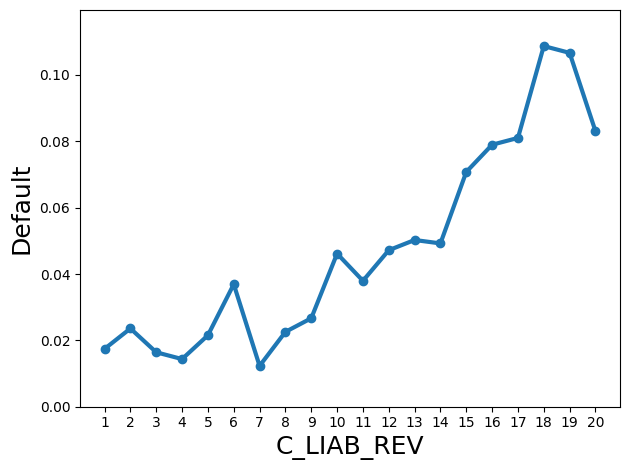

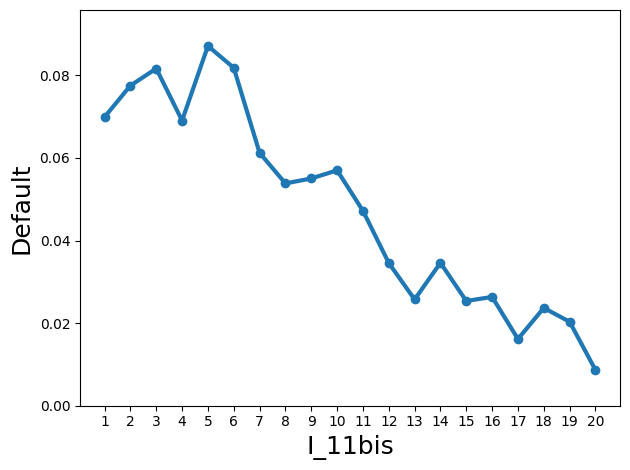

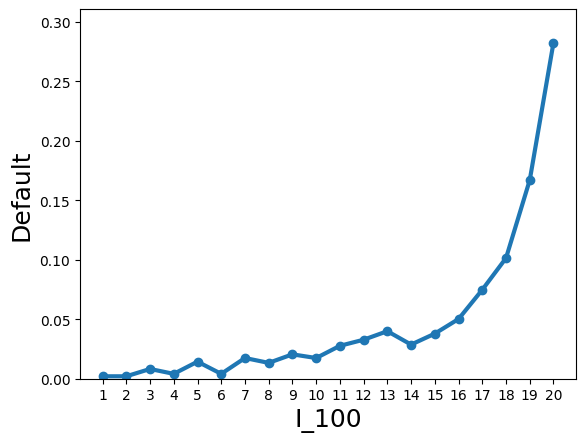

In [40]:
FEATURES_SUBSET = def_curve_feat_list

bt_sample = bt.loc[bt['IN_SAMPLE'] == 1, :]

output = tdef(
    bt_sample,
    n_bins=20,
    ind_bad='FLAG_DEF',
    subset=FEATURES_SUBSET,
    plot = True
)

In [41]:
#Adjustments

In [42]:
db = bt.copy()

db.loc[:, 'I_97_2'] = (db['I_97']-0.0711573386).where((db['I_97'] -
                                                       0.0711573386) >= 0, (db['I_97'] - 0.0711573386)*(-1))
db.loc[:, 'I_37_2'] = (db['I_37']-0.083011583).where((db['I_37'] -
                                                      0.083011583) >= 0, (db['I_37'] - 0.083011583)*(-1))
db.loc[:, 'I_27_2'] = (db['I_27']-(-0.051724138)).where((db['I_27'] -
                                                         (-0.051724138)) >= 0, (db['I_27'] - (-0.051724138))*(-1))
db.loc[:, 'I_32_2'] = (db['I_32']-0.0722722947).where((db['I_32'] -
                                                       0.0722722947) >= 0, (db['I_32'] - 0.0722722947)*(-1))
db.loc[:, 'I_34_2'] = (db['I_34']-(-0.018090011)).where((db['I_34'] -
                                                         (-0.018090011)) >= 0, (db['I_34'] - (-0.018090011))*(-1))
db.loc[:, 'mol_fat_2'] = (db['mol_fat']-(-0.127421533)).where(
    (db['mol_fat'] - (-0.127421533)) >= 0, (db['mol_fat'] - (-0.127421533))*(-1))
db.loc[:, 'P9_2'] = (db['P9']-0.7044479063).where((db['P9'] -
                                                   0.7044479063) >= 0, (db['P9'] - 0.7044479063)*(-1))
db.loc[:, 'IND_11_2'] = (db['IND_11']-0.2282051282).where(
    (db['IND_11'] - 0.2282051282) >= 0, (db['IND_11'] - 0.2282051282)*(-1))
db.loc[:, 'IND_3_2'] = (db['IND_3']-0.0711261643).where((db['IND_3'] -
                                                         0.0711261643) >= 0, (db['IND_3'] - 0.0711261643)*(-1))
db.loc[:, 'IND_8_2'] = (db['IND_8']-0.4222413422).where((db['IND_8'] -
                                                         0.4222413422) >= 0, (db['IND_8'] - 0.4222413422)*(-1))
db.loc[:, 'IND_10_2'] = (db['IND_10']-(- 0.059725453)).where(
    (db['IND_10'] - (- 0.059725453)) >= 0, (db['IND_10'] - (- 0.059725453))*(-1))
db.loc[:, 'IND_6_2'] = (db['IND_6']-0.0252849148).where((db['IND_6'] -
                                                         0.0252849148) >= 0, (db['IND_6'] - 0.0252849148)*(-1))

db = db.drop(['I_97', 'I_37', 'I_27', 'I_32', 'I_34', 'mol_fat',
             'P9', 'IND_11', 'IND_3', 'IND_8', 'IND_10', 'IND_6'], axis=1)

In [43]:
if not Application:
    vars_to_add = ['I_97_2','I_37_2','I_27_2','I_32_2','I_34_2','mol_fat_2',
                   'P9_2','IND_11_2','IND_3_2','IND_8_2','IND_10_2','IND_6_2','I_100']
    
    vars_to_drop = ['I_97', 'I_37', 'I_27', 'I_32', 'I_34', 'mol_fat',
             'P9', 'IND_11', 'IND_3', 'IND_8', 'IND_10', 'IND_6']

In [47]:
if not Application:
    # long list variable
    vars_path_pkl = path_configs + '/LongList_Variables_tab.pkl'
    longlist_vars = pd.read_pickle(vars_path_pkl)
    
    if 'APP_OUTLIER' not in longlist_vars.columns: longlist_vars['APP_OUTLIER'] = 1
    
    last_ind = longlist_vars.IND_ID.iloc[-1][3:]
    new_ids = [f'PD_{str(id)}' for id in range(int(last_ind)+1,int(last_ind)+len(vars_to_add)+1)]
    
    ind_desc = ['TBD']*len(vars_to_add)
    app_outlier = [0]*len(vars_to_add)
    
    df_add = pd.DataFrame(list(zip(new_ids, vars_to_add, ind_desc, app_outlier)),
               columns =longlist_vars.columns.to_list())
    longlist_vars_new = pd.concat([longlist_vars,df_add])
    
    longlist_vars_new['APP_PERC_MISS'] = np.where(longlist_vars_new.IND_LABEL.isin(vars_to_drop), 0, 1)
    
    ## save config in pickle file
    save_path = path_configs + '/LongList_Variables_tab_full.pkl'
    longlist_vars_new.to_pickle(save_path)

In [44]:
DEV_05_00_DEFAULT_CURVE = db.copy()

## Step 6: Calculate Percentage Missing <a name="perc_missing"></a>

- Inputs

In [46]:
db = DEV_05_00_DEFAULT_CURVE.copy()

#params
vars_path_pkl = path_configs + '/LongList_Variables_tab_full.pkl'
longlist_vars_full = pd.read_pickle(vars_path_pkl)
longlist_vars_filt = longlist_vars_full.loc[longlist_vars_full['APP_PERC_MISS']==1]

- query

In [47]:
FEATURES = longlist_vars_filt.IND_LABEL.to_list()
SUBSET = list(set(db.columns).intersection(set(['FLAG_DEF'] + FEATURES)))

in_sample = db[db['IN_SAMPLE'] == 1][SUBSET]
perf = in_sample[in_sample['FLAG_DEF'] == 1]
non_perf = in_sample[in_sample['FLAG_DEF'] == 0]

to_drop_good = perf.loc[:, perf.isnull().mean() > 0.15].columns
to_drop_bad = non_perf.loc[:, non_perf.isnull().mean() > 0.15].columns

to_drop = list(set(list(to_drop_good) + list(to_drop_bad)))

output = db.drop(to_drop, axis=1)

In [48]:
DEV_06_00_PERCENTAGE_MISSING = output.copy()

## Step 7: Calculate Accuracy Ratio FIT <a name="s7_ar_calc"></a>

- Inputs

In [50]:
db = DEV_06_00_PERCENTAGE_MISSING.copy()

#params
vars_path_pkl = path_configs + '/LongList_Variables_tab_full.pkl'
longlist_vars_full = pd.read_pickle(vars_path_pkl)

In [51]:
FEATURES = longlist_vars_full.IND_LABEL.to_list()

- query

In [52]:
db_sample = db.loc[db['IN_SAMPLE'] == 1, :]

new_cols = list(db_sample.columns)
IND_post_miss = list(set(new_cols).intersection(set(FEATURES)))
results = lorenz(
    db_sample,
    50,
    ind_bad='FLAG_DEF',
    subset=IND_post_miss
)

In [53]:
results.sort_values('auc', ascending=False)

,variable,Ar,auc
27,I_100,-0.636825,0.803342
105,C_LIAB_REV,-0.346085,0.664807
2,I_48,-0.34586,0.664706
66,DEBT_SER_COV,0.31194,0.648502
142,I_22,0.308232,0.646771
...,...,...,...
111,RICNET_IMMATBR_1,-0.004681,0.502231
46,E4,0.002653,0.501263
108,IND_37,-0.002241,0.50107
96,I_29,-0.001255,0.500599


#### <mark>PARAMS SAVE</mark> write result

In [54]:
if not Application:
    ## save config in pickle file
    save_path = path_configs + '/report_univariate_AR_tab.pkl'
    results.to_pickle(save_path)

### drop low performance inds

- query

In [55]:
if not Application:
    results = results.filter(['variable', 'Ar'], axis=1)
    vars_to_drop = list(results.loc[abs(results['Ar']) < 0.10, 'variable'])
    output = pd.DataFrame({'variable': ['vars_to_drop'],
                              'value': [vars_to_drop]})
    output = output.append(results.rename(columns={"Ar": "value"}))
    cols = ['variable', 'value']
    output = output[cols].reset_index(drop=True)
    
    DEV_07_00_ACCURACY_RATIO_STEP1 = output.copy()

/tmp/ipykernel_81/949360964.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(results.rename(columns={"Ar": "value"}))


#### <mark>PARAMS SAVE</mark> write result

In [58]:
if not Application:
    ## save config in pickle file
    save_path = path_configs + '/params_AR_tab.pkl'
    DEV_07_00_ACCURACY_RATIO_STEP1.to_pickle(save_path)

## Step 8: Calculate Accuracy Ratio Replace <a name="s7_ar_repl"></a>

- Inputs

In [56]:
db = DEV_06_00_PERCENTAGE_MISSING.copy()

#params
path = path_configs + '/params_AR_tab.pkl'
params = pd.read_pickle(path)

- query

In [57]:
params_dict = params[['variable', 'value']].set_index('variable')[
    'value'].to_dict()


to_drop = params_dict['vars_to_drop']
db_filtered = db.drop(to_drop, axis=1)

In [58]:
DEV_08_00_ACCURACY_RATIO_STEP2 = db_filtered.copy()

## Step 8b: Calculate Correct Classification Rate <a name="calc_tcorr"></a>

- Inputs

In [59]:
db = DEV_08_00_ACCURACY_RATIO_STEP2.copy()

#params
vars_path_pkl = path_configs + '/LongList_Variables_tab_full.pkl'
longlist_vars_full = pd.read_pickle(vars_path_pkl)

In [60]:
FEATURES = longlist_vars_full.IND_LABEL.to_list()

- query

In [61]:
db_sample = db.loc[db['IN_SAMPLE'] == 1, :]

new_cols = list(db_sample.columns)
IND_post_ar = list(set(new_cols).intersection(set(FEATURES)))

results = tcorr(db_sample, bad_col='FLAG_DEF', subset=IND_post_ar)

In [62]:
results

,VAR,COUNT,MISSING,PERF,MISS_PERF,PERC_MISS_PERF,TP,FP,ERROR_II,NPERF,...,FN,TF,ERROR_I,CORCL_RATE,AVG_PD,AVG_PD_PERF,AVG_PD_NPERF,AVG_PERF,AVG_NPERF,HALF_SUM
0,CAPNP_TANG_CAPNP,19674,83,18736.0,0,0.000000,13744.0,4909.0,0.263175,938.0,...,587.0,351.0,0.625800,0.555513,0.047879,0.047766,0.050136,48.423882,24.504599,36.464241
1,PASS_CORR_CAPTERZ,19674,133,18736.0,127,0.006778,7892.0,10717.0,0.575904,938.0,...,336.0,596.0,0.360515,0.531790,0.047695,0.047651,0.048557,75.294143,78.319626,76.806885
2,DUR_DEBFORN,19674,1912,18736.0,1785,0.095271,12326.0,4625.0,0.272845,938.0,...,466.0,345.0,0.574599,0.576278,0.045659,0.045460,0.049824,138.501522,174.887385,156.694453
3,DUR_CICLO,19674,1247,18736.0,1167,0.062287,11403.0,6166.0,0.350959,938.0,...,437.0,421.0,0.509324,0.569858,0.046562,0.046338,0.051161,164.821280,206.516393,185.668837
4,I_1,19674,410,18736.0,392,0.020922,7033.0,11311.0,0.616605,938.0,...,212.0,708.0,0.230435,0.576480,0.047757,0.047563,0.051629,0.039196,0.010085,0.024640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,B4,19674,1124,18736.0,1074,0.057323,9068.0,8594.0,0.486581,938.0,...,362.0,526.0,0.407658,0.552880,0.047871,0.047791,0.049446,3.728474,-1.426779,1.150847
113,B5,19674,129,18736.0,123,0.006565,11639.0,6974.0,0.374684,938.0,...,484.0,448.0,0.519313,0.553001,0.047685,0.047635,0.048676,0.028169,-0.062613,-0.017222
114,B10,19674,1298,18736.0,1233,0.065809,7942.0,9561.0,0.546249,938.0,...,297.0,576.0,0.340206,0.556772,0.047508,0.047325,0.051179,0.087747,0.057567,0.072657
115,SGF_CFL2_2,19674,321,18736.0,300,0.016012,13278.0,5158.0,0.279779,938.0,...,526.0,391.0,0.573610,0.573306,0.047383,0.047269,0.049681,-0.609819,-0.946659,-0.778239


#### <mark>PARAMS SAVE</mark> write result

In [66]:
if not Application:
    ## save config in pickle file
    save_path = path_configs + '/report_tcorr_pre_stepwise_tab.pkl'
    results.to_pickle(save_path)
    

## Step 9: Missing Values Management Fit <a name="missing_fit"></a>

- Inputs

In [67]:
if not Application:
    db = DEV_08_00_ACCURACY_RATIO_STEP2.copy()

    #params
    vars_path_pkl = path_configs + '/LongList_Variables_tab_full.pkl'
    longlist_vars_full = pd.read_pickle(vars_path_pkl)
    
    FEATURES = longlist_vars_full.IND_LABEL.to_list()

- query

In [68]:
if not Application:
    db = db.loc[db['IN_SAMPLE'] == 1, :]

    new_cols = list(db.columns)
    IND_post_ar = list(set(new_cols).intersection(set(FEATURES)))

    half_sums = pd.DataFrame({'Value': []})

    for i in IND_post_ar:
        mean_good = db.loc[db['FLAG_DEF'] == 1, i].mean()
        mean_bad = db.loc[db['FLAG_DEF'] == 0, i].mean()
        half_sums.loc[i] = (mean_good+mean_bad)/2

    half_sums.index.name = 'label'
    half_sums = half_sums.reset_index().sort_values(
        by='label').reset_index(drop=True)
    list_cols = pd.DataFrame({'label': ['list_cols'],
                                  'Value': [new_cols]})

    half_sums = list_cols.append(half_sums).reset_index(drop=True)

In [69]:
if not Application:
    DEV_09_00_NEUTRAL_NUMBERS = half_sums[['label', 'Value']].copy()

In [70]:
if not Application:
    ## save config in pickle file
    save_path = path_configs + '/params_missing_fit_tab.pkl'
    DEV_09_00_NEUTRAL_NUMBERS.to_pickle(save_path)

## Step 10: Missing Values Management Replace <a name="missing_replace"></a>

- Inputs

In [71]:
db = DEV_05_00_DEFAULT_CURVE.copy()

#params
path = path_configs + '/params_missing_fit_tab.pkl'
nn = pd.read_pickle(path)

vars_path_pkl = path_configs + '/LongList_Variables_tab_full.pkl'
longlist_vars_full = pd.read_pickle(vars_path_pkl)

FEATURES = longlist_vars_full.IND_LABEL.to_list()

- query

In [72]:
nn_dict = nn[['label', 'Value']].set_index('label')['Value'].to_dict()

list_cols = nn_dict['list_cols']
db = db.filter(list_cols, axis=1)

IND_post_ar = list(set(FEATURES) & set(list_cols))

for i in IND_post_ar:
    db[i].fillna(nn_dict[i], inplace=True)

In [73]:
DEV_10_00_MISSING_VALUE_MANAGEMENT_STEP2 = db.copy()

## Step 11: Calculate Correlation Fit <a name="biv_corr_fit"></a>

- Inputs

In [74]:
if not Application:
    db = DEV_10_00_MISSING_VALUE_MANAGEMENT_STEP2.copy()
    
    #params
    path = path_configs + '/params_AR_tab.pkl'
    params = pd.read_pickle(path)
    
    vars_path_pkl = path_configs + '/LongList_Variables_tab_full.pkl'
    longlist_vars_full = pd.read_pickle(vars_path_pkl)
    
    FEATURES = longlist_vars_full.IND_LABEL.to_list()

- query

In [75]:
if not Application:
    params_dict = params[['variable', 'value']].set_index('variable')['value'].to_dict()

    in_sample = db.loc[db['IN_SAMPLE'] == 1, :]

    new_cols = list(in_sample.columns)
    IND_post_AR = list(set(new_cols).intersection(set(FEATURES)))

In [76]:
if not Application:
    results = matrix_corr(
        in_sample,
        subset=IND_post_AR,
        alt=True
    )

    results.loc[:, 'abs_ar1'] = results.apply(
        lambda x: abs(params_dict[x['Var1']]), axis=1)
    results.loc[:, 'abs_ar2'] = results.apply(
        lambda x: abs(params_dict[x['Var2']]), axis=1)
    results.loc[:, 'abs_corr'] = abs(results['Correlation'])


#### <mark>PARAMS SAVE</mark> write result

In [77]:
if not Application:
    ## save config in pickle file
    save_path = path_configs + '/report_bivariate_corr_tab.pkl'
    DEV_11_01_CORRELATION_Report = results
    DEV_11_01_CORRELATION_Report.to_pickle(save_path)

## Step 11B: Calculate Correlation Replace <a name="biv_corr_replace"></a>

- Inputs

In [78]:
db = DEV_10_00_MISSING_VALUE_MANAGEMENT_STEP2.copy()
    
#params
path = path_configs + '/report_bivariate_corr_tab.pkl'
results = pd.read_pickle(path)
    
vars_path_pkl = path_configs + '/LongList_Variables_tab_full.pkl'
longlist_vars_full = pd.read_pickle(vars_path_pkl)
    
FEATURES = longlist_vars_full.IND_LABEL.to_list()

In [79]:
results = results.loc[(results['abs_corr'] != 1) &
                      (results['abs_corr'] > 0.5), :]
results = results.sort_values(
    by=['abs_ar1', 'abs_ar2'], ascending=False).reset_index(drop=True)

to_drop = []
results_new = results
while not (results_new.empty):
    new_var = str(np.where(results_new.loc[0, 'abs_ar1'] > results_new.loc[0,
                  'abs_ar2'], results_new.loc[0, 'Var2'], results_new.loc[0, 'Var1']))
    to_drop.append(new_var)
    results_new = results_new.loc[(results_new['Var1'] != new_var) & (
        results_new['Var2'] != new_var), :].reset_index(drop=True)

db_final = db.drop(to_drop, axis=1).reset_index(drop=True)

In [80]:
DEV_11_00_CORRELATION = db_final.copy()

## Step 12: StepWise 5Percent <a name="stepwise_5perc"></a>

- Inputs

In [81]:
if not Application:
    db = DEV_11_00_CORRELATION.copy()

    #params
    vars_path_pkl = path_configs + '/LongList_Variables_tab_full.pkl'
    longlist_vars_full = pd.read_pickle(vars_path_pkl)

    FEATURES = longlist_vars_full.IND_LABEL.to_list()

- query

In [82]:
if not Application:
    in_sample = db.loc[db['IN_SAMPLE'] == 1, :]

    new_cols = list(in_sample.columns)
    IND_post_corr = list(set(new_cols).intersection(set(FEATURES)))

    results = stepwise_binomial(in_sample, y_col='FLAG_DEF',
                                subset=IND_post_corr, threshold_in=0.05,
                                threshold_out=0.05)#, verbose=True)

#### <mark>PARAMS SAVE</mark> write result

In [83]:
if not Application:
    ## save config in pickle file
    save_path = path_configs + '/model_stepwise_5perc_raw.pkl'
    with open(save_path, 'wb') as file:
        pickle.dump(results, file)

In [84]:
if not Application:
    db = results[0]
    list_vars = list(db['Var'])[1:]
    output = pd.DataFrame({'Var': ['list_vars'],
                              'coef': [list_vars]})

    output = output.append(db).reset_index(drop=True)
    
    

#### <mark>PARAMS SAVE</mark> write result

In [85]:
if not Application:
    ## save config in pickle file
    save_path = path_configs + '/params_model_stepwise_5perc_tab.pkl'
    DEV_12_00_STEPWISE_5_PERCENT = output[['Var', 'coef']]
    DEV_12_00_STEPWISE_5_PERCENT.to_pickle(save_path)

## Step 13: StepWise 1 Percent <a name="stepwise_1perc"></a>

- Inputs

In [94]:
if not Application:
    db = DEV_11_00_CORRELATION.copy()

    #params
    vars_path_pkl = path_configs + '/LongList_Variables_tab_full.pkl'
    longlist_vars_full = pd.read_pickle(vars_path_pkl)

    FEATURES = longlist_vars_full.IND_LABEL.to_list()
    
    path = path_configs + '/params_model_stepwise_5perc_tab.pkl'
    model = pd.read_pickle(path)
    
    path_params = path_configs + '/params_stepwise.xlsx'
    params = pd.read_excel(path_params)
    
    th_in = float(params.THRESH_IN[0])
    th_out = float(params.THRESH_OUT[0])
    
    

- query

In [96]:
if not Application:
    in_sample = db.loc[db['IN_SAMPLE'] == 1, :]
    
    params_dict = model[['Var', 'coef']].set_index('Var')['coef'].to_dict()

    list_vars = params_dict['list_vars']

    new_cols = list(in_sample.columns)
    IND_post_step5 = list(set(new_cols).intersection(set(list_vars)))

In [98]:
if not Application:
    results = stepwise_binomial(
    in_sample,
    y_col='FLAG_DEF',
    subset=IND_post_step5,
    threshold_in=th_in,
    threshold_out=th_out)

#### <mark>PARAMS SAVE</mark> write result

In [100]:
if not Application:
    ## save config in pickle file
    save_path = path_configs + '/model_stepwise_1perc_raw.pkl'
    with open(save_path, 'wb') as file:
        pickle.dump(results, file)

In [101]:
if not Application:
    db = results[0]
    list_vars = list(db['Var'])[1:]
    output = pd.DataFrame({'Var': ['list_vars'],
                              'coef': [list_vars]})

    output = output.append(db).reset_index(drop=True)

/tmp/ipykernel_156/9476043.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(db).reset_index(drop=True)


#### <mark>PARAMS SAVE</mark> write result

In [103]:
if not Application:
    ## save config in pickle file
    save_path = path_configs + '/params_model_stepwise_1perc_tab.pkl'
    DEV_13_00_STEPWISE_1_PERCENT  = output[['Var', 'coef']]
    DEV_13_00_STEPWISE_1_PERCENT.to_pickle(save_path)

## Step 14-MOD: Expert Final Model <a name="final_model"></a>

In [110]:
#model auto    
path = path_configs + '/model_stepwise_1perc_raw.pkl'
model_raw = pd.read_pickle(path)

In [138]:
model_summary = model_raw[0]
format_cols = {c: 'float' for c in model_summary.columns if c!='Var'}
model_summary = model_summary.astype(format_cols)
model_summary.dtypes

Var         object
coef       float64
std err    float64
z          float64
P>|z|      float64
[0.025     float64
0.975]     float64
dtype: object

In [139]:
model_summary.head()

,Var,coef,std err,z,P>|z|,[0.025,0.975]
0,const,-5.076893,0.228,-22.315,0.0,-5.523,-4.631
1,I_100,7.773130,0.217,35.769,0.0,7.347,8.199
2,I_19,-4.965106,0.290,-17.123,0.0,-5.533,-4.397
3,IC_188,-5.406342,1.285,-4.206,0.0,-7.925,-2.887
4,I_73,-1.265765,0.147,-8.592,0.0,-1.555,-0.977


In [157]:
#Highest weights
weight_feats = model_summary.sort_values(by='coef', key=abs, ascending=False)['Var'][0:8].to_list()

# by Z score
z_feats = model_summary.sort_values(by='z', key=abs, ascending=False)['Var'][0:8].to_list()

Candidate_feats = list(set(weight_feats).intersection(set(z_feats)))

In [158]:
Candidate_feats

['I_19', 'I_100', 'const', 'I_73', 'IND_49', 'IC_188']

In [162]:
final_model = model_summary.loc[model_summary['Var'].isin(Candidate_feats)]
final_model

,Var,coef,std err,z,P>|z|,[0.025,0.975]
0,const,-5.076893,0.228,-22.315,0.0,-5.523,-4.631
1,I_100,7.773130,0.217,35.769,0.0,7.347,8.199
2,I_19,-4.965106,0.290,-17.123,0.0,-5.533,-4.397
3,IC_188,-5.406342,1.285,-4.206,0.0,-7.925,-2.887
4,I_73,-1.265765,0.147,-8.592,0.0,-1.555,-0.977
9,IND_49,0.560556,0.151,3.705,0.0,0.264,0.857


In [163]:
if not Application:
    db = final_model
    list_vars = list(db['Var'])[1:]
    output = pd.DataFrame({'Var': ['list_vars'],
                              'coef': [list_vars]})

    output = output.append(db).reset_index(drop=True)

/tmp/ipykernel_156/1006569128.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(db).reset_index(drop=True)


#### <mark>PARAMS SAVE</mark> write result

In [165]:
if not Application:
    ## save config in pickle file
    save_path = project_path + '/model_final_tab.pkl'
    output.to_pickle(save_path)
    
    ## save config in pickle file
    save_path = path_configs + '/params_model_final_tab.pkl'
    PARAMS_MODEL_FINAL  = output[['Var', 'coef']]
    PARAMS_MODEL_FINAL.to_pickle(save_path)

## Step 14: Compute Score And Probabilities <a name="score_prob"></a>

- Inputs

In [20]:
db = DEV_11_00_CORRELATION.copy()

#model final    
path = project_path + '/model_final_tab.pkl'
model_full = pd.read_pickle(path)
model = model_full[['Var', 'coef']]

In [22]:
model

,Var,coef
0,list_vars,"[I_100, I_19, IC_188, I_73, IND_49]"
1,const,-5.076893
2,I_100,7.77313
3,I_19,-4.965106
4,IC_188,-5.406342
5,I_73,-1.265765
6,IND_49,0.560556


- query

In [174]:
params_dict = model[['Var', 'coef']].set_index('Var')['coef'].to_dict()

output = pd.DataFrame()

const = float(params_dict['const'])
list_vars = params_dict['list_vars']

score = [const]*len(db)

for i in list_vars:
    score = score + float(params_dict[i])*db.loc[:, i]
output.loc[:, 'SCORE'] = score
output.loc[:, 'PRED_PROB'] = 1/(1+np.exp((-1)*np.array(score)))

keys = db[['REF_DATE', 'BIC', 'CIC']]
final = pd.concat([keys, output], axis=1)

In [176]:
DEV_14_00_SCORES_AND_PROBABILITIES = final.copy()

## Step 15A: Calculate Performance_ar <a name="report_AR"></a>

- Inputs

In [179]:
scores = DEV_14_00_SCORES_AND_PROBABILITIES.copy()
mvm = DEV_10_00_MISSING_VALUE_MANAGEMENT_STEP2.copy()

- query

In [180]:
db = mvm.merge(
    scores,
    how='inner',
    on=['BIC', 'CIC', 'REF_DATE'],
    suffixes=('', '__17_SCORES_AND_PROBABILITIES_00')
)[['REF_DATE', 'BIC', 'CIC', 'SCORE', 'PRED_PROB', 'FLAG_DEF', 'IN_SAMPLE']]

In [181]:
results_AR = lorenz(
    db,
    ind_bad='FLAG_DEF',
    subset=['SCORE'],
    gbkey=['IN_SAMPLE']
)


#### <mark>REPORT SAVE</mark> write result

In [185]:
## save config in pickle file
save_path = out_path + '/report_final_model_AR_tab.pkl'
results_AR.reset_index().to_pickle(save_path)

In [26]:
path = out_path + '/report_final_model_AR_tab.pkl'
results_AR = pd.read_pickle(path)

In [27]:
results_AR

,IN_SAMPLE,level_1,variable,Ar,auc
0,0,0,SCORE,-0.72657,0.846267
1,1,0,SCORE,-0.753961,0.859007


## Step 15B: Calculate Performance_tcorr <a name="report_TCORR"></a>

- Inputs

In [186]:
scores = DEV_14_00_SCORES_AND_PROBABILITIES.copy()
mvm = DEV_10_00_MISSING_VALUE_MANAGEMENT_STEP2.copy()

- query

In [187]:
db = mvm.merge(
    scores,
    how='inner',
    on=['BIC', 'CIC', 'REF_DATE'],
    suffixes=('', '__17_SCORES_AND_PROBABILITIES_00')
)[['REF_DATE', 'BIC', 'CIC', 'SCORE', 'PRED_PROB', 'FLAG_DEF', 'IN_SAMPLE']]

In [189]:
results_TCORR = tcorr(
    db,
    bad_col='FLAG_DEF',
    subset=['SCORE'],
    gbkey=['IN_SAMPLE']
)


#### <mark>REPORT SAVE</mark> write result

In [192]:
## save config in pickle file
save_path = path_configs + '/report_final_model_TCORR_tab.pkl'
results_TCORR.reset_index().to_pickle(save_path)

## Step 15-3: Calculate Performance_tdef <a name="report_TDEF"></a>

- Inputs

In [193]:
scores = DEV_14_00_SCORES_AND_PROBABILITIES.copy()
mvm = DEV_10_00_MISSING_VALUE_MANAGEMENT_STEP2.copy()

- query

In [197]:
db = mvm.merge(
    scores,
    how='inner',
    on=['BIC', 'CIC', 'REF_DATE'],
    suffixes=('', '__17_SCORES_AND_PROBABILITIES_00')
)[['REF_DATE', 'BIC', 'CIC', 'SCORE', 'PRED_PROB', 'FLAG_DEF', 'IN_SAMPLE']]

In [199]:
results_def_rate = tdef(
    db,
    n_bins=10,
    ind_bad='FLAG_DEF',
    subset=['SCORE'],
    gbkey=['IN_SAMPLE'],
)


#### <mark>REPORT SAVE</mark> write result

In [201]:
## save config in pickle file
save_path = path_configs + '/report_final_model_TDEF_tab.pkl'
results_def_rate.reset_index().to_pickle(save_path)

In [204]:
print('DONE...')

DONE...
